In [35]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas
import os, shutil, time, pdb, random, pickle
import scipy.stats as stats 

from IPython.display import clear_output

from math import pi
from datetime import datetime
from collections import OrderedDict

import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [36]:
from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *
from elbo import *

In [37]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
%matplotlib inline
# import seaborn as sns
# sns.set_theme()
pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.rc_file_defaults()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from plum import dispatch
from varz.torch import Vars
import torch.nn as nn
from stheno.torch import B, GP, EQ, Normal, Measure
from matrix import Diagonal

# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [39]:
from gp_mlp import *

In [40]:
# # Import Beas and Sutlej shapefiles
# beas_shp = '/Users/marron31/Google Drive/PhD/gis/exports/beas_watershed.shp'
# sutlej_shp = '/Users/marron31/Google Drive/PhD/gis/exports/sutlej_watershed.shp'

# beas = geopandas.read_file(beas_shp)
# sutlej = geopandas.read_file(sutlej_shp)

# catchments = beas.append(sutlej)

In [41]:
# Let all of Stheno run on that device.
B.device(device).__enter__()
B.epsilon = 1e-1  # Needs to be relatively high for `float32`s
# B.epsilon is the default value for the diagonal jitter of the matrix

/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/lab/generic.py:296: DeprecationWarning: The use of `device` to change the active device is deprecated. Please use `on_device` instead.
  warnings.warn(


In [42]:
# Parameters
start="1900-01-01"
end="2020-12-31"

TRAIN_PATH = "../../data/norris/enriched_obs/enriched_langtang_obs_norris_ready.pkl"
TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF.pkl'
# TEST_PATH = "../data/pickle/df_stations_val_all_nonzero_extended.pkl"
# TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF.pkl'

In [43]:
"""

df = pd.read_pickle('../../data/idaweb/observations_enriched_WRF.pkl')
# df.rename(columns={"stn":"Station"}, inplace=True)

# Calculate Day of Year
df['DOY'] = df['date'].dt.dayofyear

# Apply cosine and sine transformations
# Note: np.cos and np.sin expect radians, so we scale DOY to [0, 2π] range
df['doy_sin'] = np.cos(2 * np.pi * df['DOY'] / 365.25)
df['doy_cos'] = np.sin(2 * np.pi * df['DOY'] / 365.25)

df.rename(columns={'Elevation [m]':'Z'},inplace=True)

df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df['Z'] = pd.to_numeric(df['Z'], errors='coerce')
# df = df.dropna()


df = df[['Station', 
# 'time', 'rka150d0', 'qrka150d0', 'mrka150d0', 'date', 'rre150d0', 'qrre150d0', 'mrre150d0', 'rka150d0_flag', 'rre150d0_flag',
   'month', 'year', 'Prec', 
#     'Name', 'Data source', 'Longitude/Latitude', 'Coordinates [km]', 
    'Z', 
#     'Lon', 'Lat', 
    'X', 'Y', 'Date',
         'doy_sin','doy_cos',
   'W500', 'RH2', 'U500', 'V10', 'RH500', 'RAIN', 'U10', 'V500', 'T2MIN','T2', 'T2MAX']]

df = df.dropna()

df = df.drop_duplicates(subset=['X','Y','Z','RAIN','doy_sin', 'doy_cos','year'])

df.to_pickle('../../data/idaweb/observations_enriched_WRF_reduced.pkl')

"""

'\n\ndf = pd.read_pickle(\'../../data/idaweb/observations_enriched_WRF.pkl\')\n# df.rename(columns={"stn":"Station"}, inplace=True)\n\n# Calculate Day of Year\ndf[\'DOY\'] = df[\'date\'].dt.dayofyear\n\n# Apply cosine and sine transformations\n# Note: np.cos and np.sin expect radians, so we scale DOY to [0, 2π] range\ndf[\'doy_sin\'] = np.cos(2 * np.pi * df[\'DOY\'] / 365.25)\ndf[\'doy_cos\'] = np.sin(2 * np.pi * df[\'DOY\'] / 365.25)\n\ndf.rename(columns={\'Elevation [m]\':\'Z\'},inplace=True)\n\ndf[\'X\'] = pd.to_numeric(df[\'X\'], errors=\'coerce\')\ndf[\'Y\'] = pd.to_numeric(df[\'Y\'], errors=\'coerce\')\ndf[\'Z\'] = pd.to_numeric(df[\'Z\'], errors=\'coerce\')\n# df = df.dropna()\n\n\ndf = df[[\'Station\', \n# \'time\', \'rka150d0\', \'qrka150d0\', \'mrka150d0\', \'date\', \'rre150d0\', \'qrre150d0\', \'mrre150d0\', \'rka150d0_flag\', \'rre150d0_flag\',\n   \'month\', \'year\', \'Prec\', \n#     \'Name\', \'Data source\', \'Longitude/Latitude\', \'Coordinates [km]\', \n    \'Z\', \

In [44]:
TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF_reduced.pkl'

In [45]:
predictant = ['Prec']
predictors = [
              #'Date',
              #'Station',
              #'Prec',
              #'Corrected Station Name', 
              'X', 'Y',
              #'Altitude (m)', 
#               'Z', 
#               'RAIN', #'wrf_bc_prcp', 
              #'elev_hr', 
              #'aspect','slope', 
              #'doy', 
              'doy_sin', 'doy_cos', 
              'W500', 'RH2', 'U500', 'V10', 'RH500', 'RAIN', 'U10', 'V500', 'T2MIN',
              'T2', 'T2MAX'
              #'wrf_prcp_-1', 'wrf_prcp_-2','wrf_prcp_1', 'wrf_prcp_2', 
              #'Basin', 'lon', 'lat', 
#               'era5_u', 'era5_v',
              #'era5_u_-2', 'era5_u_-1', 'era5_u_1', 'era5_u_2', 
              #'era5_v_-2', 'era5_v_-1', 'era5_v_1', 'era5_v_2'
             ]

In [46]:
# root_folder = '../../data/norris/enriched_obs/enriched_langtang_obs_norris_ready.pkl'

In [47]:
TEST_PATH = r'/users/marron31/data/idaweb/maps_for_predictions/1991-06-03.csv'

In [48]:
stations_langtang = ['Tipping Bucket Lama Hotel', 
                    'Tipping Bucket Langtang',
                   'Tipping Bucket Kyanjing', 
#                    'Tipping Bucket Numthang old',
#                    'Tipping Bucket Jathang', 
#                     'Pluviometer Yala', 
#                     'AWS Kyangjing',
#                    'AWS Yala BC', 
                    'Tipping Bucket Ganja La 3',
                   'Tipping Bucket Ganja La 2',
                   'Tipping Bucket Langshisha Glacier (next to Pluviometer)',
                   'Tipping Bucket Ganja La 1',
                    'Tipping Bucket Langshisha BC',
                   'Tipping Bucket Shalbachum',
#                    'Pluviometer Langshisha Glacier (off-glacier)',
                   'Pluviometer GanjaLa', 'Pluviometer Morimoto']

exclusion_list = ['Tipping Bucket Numthang old', 'Tipping Bucket Jathang',
                   'Pluviometer Langshisha Glacier (off-glacier)', 'Pluviometer Yala',
                   'AWS Kyangjing', 'AWS Yala BC']

[s not in exclusion_list for s in stations_langtang]

sublist = ['AWS Kyangjing', 'AWS Yala BC', 'Pluviometer Yala']

In [49]:
# Initially used to create split but then manually setting stations because there is some issue with stations missing after data preparation process
# pick 10% random stations for validation, 10% for testing and the rest for training
stations = list(pd.read_pickle(TRAIN_PATH).Station.unique())
random.shuffle(stations)
val_stations = stations[:int(len(stations)*0.1)]
test_stations = stations[int(len(stations)*0.1):int(len(stations)*0.2)]
train_stations = stations[int(len(stations)*0.2):]

In [50]:
train_stations = ['ABO', 'AHO', 'AIR', 'ALV', 'APT', 'ARO', 'AUB', 'AVA', 'AVB', 'BAC', 'BAL', 'BEA', 'BEC', 'BEGTH', 'BEGWA', 'BEH', 'BEHAK', 'BEKSE', 'BERIF', 'BES', 'BEV', 'BIN', 'BIV', 'BLA', 'BRA', 'BRW', 'BSP', 'BSW', 'CAV', 'CDF', 'CHA', 'CHB', 'CHD', 'CHM', 'CHW', 'CIM', 'COV', 'CTA', 'CTO', 'CUE', 'DAV', 'DIB', 'DIS', 'DLBAL', 'DLFEB', 'DLZUG', 'DMA', 'DOL', 'EIT', 'ENG', 'ERN', 'EVL', 'EVO', 'FIL', 'FIO', 'FIT', 'FLI', 'FRE', 'GEN', 'GOA', 'GRC', 'GRH', 'GSB', 'GSG', 'GST', 'GTT', 'GWA', 'HER', 'HIR', 'HOE', 'INF', 'IYDEO', 'IYDEU', 'IYMMR', 'IYMUW', 'IYPEN', 'IYPFE', 'IYPFI', 'IYPLI', 'IYPRU', 'IYREI', 'IYRID', 'IYROT', 'IYSMG', 'IYSMT', 'IYSUL', 'IYSUM', 'IYSVP', 'IYSWA', 'IYTER', 'IYTOB', 'IYULT', 'IYVAA', 'IYVAL', 'IYWEL', 'IYWOL', 'KLA', 'KRO', 'KSE', 'LBA', 'LEH', 'LEU', 'LOC', 'LOE', 'MAL', 'MAT', 'MAU', 'MLS', 'MOD', 'MSO', 'MST', 'MTE', 'MUE', 'MUS', 'MVE', 'NABCHA', 'NABDAV', 'NAP', 'NEB', 'OBI', 'OBW', 'PDM', 'PIG', 'PIL', 'PLF', 'PON', 'PSB', 'PUD', 'REC', 'ROB', 'ROE', 'ROG', 'RUM', 'SAB', 'SAE', 'SAF', 'SAM', 'SAN', 'SAP', 'SAS', 'SBA', 'SBE', 'SCU', 'SDO', 'SED', 'SEP', 'SGD', 'SIA', 'SIM', 'SLFAM2', 'SLFEM2', 'SLFFIS', 'SLFGL2', 'SLFMEI', 'SLFOBM', 'SLFSA3', 'SLFSC2', 'SLFSC3', 'SLFTU2', 'SLFUR2', 'SLFURS', 'SNE', 'SOG', 'SRL', 'STP', 'SVG', 'SWA', 'TIBED', 'TIBIA', 'TICOL', 'TIFUS', 'TIOLI', 'TST', 'UNS', 'URB', 'VDLSP', 'VDSEP', 'VEL', 'VIO', 'VRI', 'VSANZ', 'VSARO', 'VSBRI', 'VSCHY', 'VSDUR', 'VSEMO', 'VSFIN', 'VSGDX', 'VSJEI', 'VSMAT', 'VSSAB', 'VSSTA', 'VST', 'VSVER', 'WAW', 'WET', 'ZER', 'ZEV', 'ZNZ']
val_stations = ['ANT', 'BEHAB', 'BIO', 'BOS', 'BRL', 'BUF', 'ELO', 'FIE', 'GRY', 'GUE', 'IYHIN', 'IYTAU', 'KAS', 'LAT', 'LBG', 'MEB', 'RIE', 'SLFSH2', 'SLFSP2', 'SMM', 'SMZ', 'TICVM', 'VAB', 'VSMOI', 'VSTSN']
len(train_stations), len(val_stations)

(199, 25)

In [51]:
ds_dataset = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=train_stations)
ds_dataset_val = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=val_stations)
# ds_dataset_test = UpperIndusDataset(TRAIN_PATH, start, end, predictant, predictors, stations=test_stations)
# ds_dataset_map = UpperIndusDataset(TEST_PATH, start, end, predictant, predictors, stations=test_stations)

train_mean = ds_dataset.mean
train_var = ds_dataset.var

/users/marron31/repos/upper-indus-prec-bc/preprocessing_utils.py:278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[series][df[series] < 0] = 0
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/xarray/core/pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version ins

In [52]:
train_dataloader = DataLoader(dataset=ds_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(dataset=ds_dataset_val, batch_size=16, shuffle=True)
# dataloader_test = DataLoader(dataset=ds_dataset, batch_size=16, shuffle=True)
# test_dataloader = dataloader_test

In [53]:
ds_dataset_map = MapDataset(TEST_PATH, predictors, train_mean, train_var)
dataloader_map = DataLoader(dataset=ds_dataset_map, batch_size=1, shuffle=False)

# MODELS

In [54]:
model = MLP(in_channels= len(predictors)-1, 
            hidden_channels=[50,50], 
            likelihood_fn='bgmm', # 'gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 3453


In [55]:
MLP = MLP(in_channels= len(predictors), 
            hidden_channels=[50,50], 
            likelihood_fn='bgmm', # 'gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
           )

print(f'Number of parameters: {sum(p.numel() for p in MLP.parameters())}')

Number of parameters: 3503


In [56]:
model.to(device)
MLP.to(device);

In [57]:
def reset_weights(m):
    '''
    This function resets model weights randomly following the original initialization method.
    Works for simple architectures and commonly used layers.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # If the layer has the method `reset_parameters`, it will be called
            layer.reset_parameters()

### MLP

In [26]:
MLP.apply(reset_weights);

In [ ]:
train_losses = []
val_losses = []
test_losses = []

train_loader = train_dataloader
valid_loader = val_dataloader
# test_loader = dataloader

epochs = 30

optimizer = torch.optim.Adam(MLP.parameters(), lr=0.0001)

for epoch in range(epochs):
    
    epoch_train_losses, epoch_val_losses = [], []
    
    MLP.train()
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        inputs = inputs.float().to(device) # [batch_size, num_stations, num_predictiors]
        labels = labels.float().to(device) # [batch_size, num_stations]
        
        inputs = inputs.permute([0,2,1])
        batch_size = inputs.shape[0]
        
        optimizer.zero_grad()
        
        outputs = MLP(inputs)

        loss = loss_fn(outputs, labels, inputs, MLP, reduction='sum')/batch_size 
        # print('train: ', epoch, i, loss.item())
        
        if loss.item() != 0: 
            
            loss.backward()
            
            for param in optimizer.param_groups[0]['params']:
                nn.utils.clip_grad_value_(param, 1) # Bit of regularisation

            optimizer.step()
        
        epoch_train_losses.append(loss.item())
        
        #train_loss, val_loss, test_loss = train_epoch(MLP, optimizer, train_loader, valid_loader, test_loader=test_loader, print_progress=True, epoch=epoch, device=device, permute=True)

    model.eval()
    
    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(val_dataloader):

            inputs = inputs.float().to(device) # [batch_size, num_stations, num_predictiors]
            labels = labels.float().to(device) # [batch_size, num_stations]
        
            inputs = inputs.permute([0,2,1])
            batch_size = inputs.shape[0]
            
            outputs = MLP(inputs)
            
#             pdb.set_trace()
            
#             assert inputs.isnan().sum() == 0
#             assert outputs.isnan().sum() == 0
#             assert labels.isnan().sum() == 0

#             # device = labels.device
#             logp = torch.zeros_like(labels, device=device)
    
#             b_mask = labels == 0 # shape (b, n_samples, k)
#             g_mask = labels > 0

#             # shape of outputs: (b, num_stations, n_samples, num_output_dims)
   
#             pi = outputs[...,0] # shape (b, num_stations, n_samples)
#             alpha = outputs[...,1] # shape (b, num_stations, n_samples)
#             beta = outputs[...,2] # shape (b, num_stations, n_samples)

#             # Computing log probabilities for gamma distribution where obs > 0
#             gamma_dist = Gamma(concentration=alpha[g_mask], rate=beta[g_mask])
#             logp[g_mask] = torch.log((1 - pi[g_mask])) + gamma_dist.log_prob(labels[g_mask])
    
#             # Computing log probabilities for Bernoulli distribution where obs == 0
#             logp[b_mask] = torch.log(pi[b_mask])

#             if mask is not None:
#                 logp = logp * mask

            loss = loss_fn(outputs, labels, inputs, MLP, reduction='sum')/batch_size
            # print('val: ', epoch, i, loss.item())

            epoch_val_losses.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_losses)/len(train_stations) 
    epoch_val_loss = np.mean(epoch_val_losses)/len(val_stations) #, np.mean(test_losses)
    
    print(f'epoch : {epoch+1}, train loss : {np.mean(epoch_train_loss):.4f} , valid loss : {np.mean(epoch_val_loss):.4f}')
   
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
#     test_losses.append(test_loss)

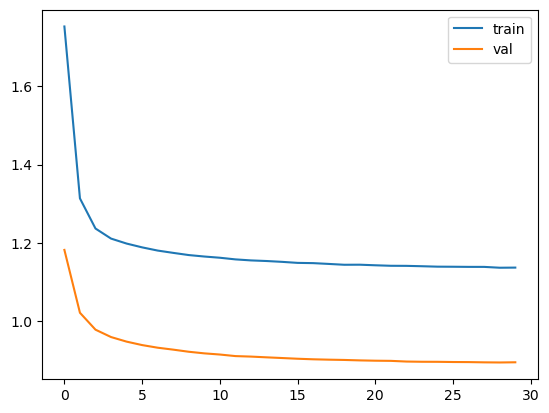

In [38]:
plt.plot(np.array(train_losses), label='train')
plt.plot(np.array(val_losses), label='val')
plt.legend()
plt.show()

### GP-MLP

In [58]:
model.apply(reset_weights);

In [59]:
print_progress = True
plot_x_ind = True
validate_flag = True
f_marginal_flag = False
mc_samples = 5

In [60]:
# arr, _ = UpperIndusGridDataset(root_folder, train_mean, train_var).__getitem__(10)

# x_min = arr[0,:].min()
# x_max = arr[0,:].max() 
# y_min = arr[1,:].min()
# y_max = arr[1,:].max()

In [61]:
st = ds_dataset.st
st_val = ds_dataset_val.st
coords_train_stations = st.groupby('Station').mean()[['X','Y']].values
coords_val_stations = st_val.groupby('Station').mean()[['X','Y']].values

x_ind_stations = coords_train_stations

coords_train_stations.shape, coords_val_stations.shape

((199, 2), (25, 2))

In [72]:
# Number of points for inducing points grid
# x_points = 30
# y_points = 30

#  Grid of equally spaced points covering the spatial extent for which station data is available
# grid = np.meshgrid(np.linspace(st['X'].min(),st['X'].max(),x_points),np.linspace(st['Y'].min(),st['Y'].max(),y_points))
# grid = np.meshgrid(np.linspace(x_min,x_max,x_points),np.linspace(y_min,y_max,y_points))

# Make grid into a tensor
# grid = torch.tensor(grid, dtype=torch.float32).flatten(start_dim=1).permute(1,0)

# x_ind = grid.clone().detach().requires_grad_(True)
# num_ind_points = x_points * y_points
    
# Inducing points are points in the station
# x_ind = torch.tensor(x_ind_stations, dtype=torch.float32).detach().requires_grad_(False).to(device)
x_ind = torch.nn.Parameter(torch.tensor(x_ind_stations, dtype=torch.float32, requires_grad=True).to(device))
num_ind_points = len(x_ind)

n = len(st)

# model.train()
# prior = Measure()

ls = torch.nn.Parameter(torch.tensor(2, dtype=torch.float32, requires_grad=True).to(device))

with Measure() as prior:
    #f1 = GP(EQ().stretch(100))
    #f2 = GP(EQ().stretch(10))
    f3 = GP(EQ().stretch(ls))
    f = f3 #f1 + f2 + f3

# f = GP(EQ().stretch(0.5)) # f is drawn from a GP
 
q = ApproximatePosterior(num_ind_points) # q is the approximate posterior

# optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters())+[x_ind], lr=10e-3)
optimizer = torch.optim.Adam(list(model.parameters())+list(q.parameters())+[x_ind, ls], lr=10e-4)

In [73]:
load_model = False
exp_name = '[50_50]'

if load_model:
    q.load_state_dict(torch.load(f'q_state_{exp_name}.pth'))
    optimizer.load_state_dict(torch.load(f'optimizer_state_{exp_name}.pth'))
    model.load_state_dict(torch.load(f'model_state_{exp_name}.pth'))

    # Load the data back
    with open(f'training_progress_{exp_name}.pkl', 'rb') as file:
        data_loaded = pickle.load(file)

    e_past = data_loaded["last_epoch"]
    train_loss = data_loaded["train_loss"]
    train_loglik = data_loaded["train_loglik"]
    train_kl = data_loaded["train_kl"]
    train_nll = data_loaded["train_nll"]
    val_loss = data_loaded["val_loss"]
    val_loglik = data_loaded["val_loglik"]
    val_kl = data_loaded["val_kl"]
    val_nll = data_loaded["val_nll"]

else:
    e_past = 0
    train_loss, train_loglik, train_kl, train_nll = [], [], [], []
    val_loss, val_loglik, val_kl, val_nll = [], [], [], []

test_loss, test_loglik, test_kl, test_nll  = [], [], [], []

train_loss_batch, train_loglik_batch, train_kl_batch, train_nll_batch = RunningAverage(), RunningAverage(), RunningAverage(), RunningAverage()
val_loss_batch, val_loglik_batch, val_kl_batch, val_nll_batch = RunningAverage(), RunningAverage(), RunningAverage(),RunningAverage()

In [74]:
num_epochs = 25
    
for e in range(e_past + 1, num_epochs):

    torch.cuda.empty_cache()
    # print_gpu_usage()
    
    # TRAIN EPOCH    
    model.train()
        
#     if plot_x_ind and (e % 10 == 0):
#         fig, ax = plt.subplots(figsize=(5,5))
#         ax.scatter(x_ind.detach()[:,0].cpu(),
#                    x_ind.detach()[:,1].cpu()
#                   )
#         plt.show()

    start = time.time()

    train_loss_batch.reset()
    train_loglik_batch.reset()
    train_kl_batch.reset()
    train_nll_batch.reset()
    val_loss_batch.reset()
    val_loglik_batch.reset()
    val_kl_batch.reset()
    val_nll_batch.reset()

    n = train_dataloader.dataset.n
    
    for i, (inputs, labels) in enumerate(train_dataloader):

        inputs = inputs.to(device) # inputs [batch_size, num_predictors, num_stations]
        labels = labels.to(device) # labels [batch_size, num_stations]

        elbo, recon, kl, num_points, nll = forward_backward_pass(inputs, labels, n, model, optimizer, q, f, x_ind, 
                                                            inducing_points=True, backward=True, f_marginal=f_marginal_flag, n_samples=mc_samples)

        # Keep track of loss terms
        train_loss_batch.update(-elbo.item())
        train_loglik_batch.update(-recon.item())
        train_kl_batch.update(kl.item())
        train_nll_batch.update(nll.item()/num_points.item())

    elapsed = time.time() - start

    if print_progress:
        print(f'Train epoch  {e}: -elbo: {train_loss_batch.avg:.3f} | kl: {train_kl_batch.avg:.3f} | -recon: {train_loglik_batch.avg:.3f} | nll: {train_nll_batch.avg:.3f} -- time: {elapsed:.2f}')
        print(f'GP lengthscale: {ls.item()}')

    # Add average batch loss terms to lists
    train_loss.append(train_loss_batch.avg)
    train_loglik.append(train_loglik_batch.avg)
    train_kl.append(train_kl_batch.avg)
    train_nll.append(train_nll_batch.avg)
    
    # VALIDATION EPOCH
    if validate_flag:

        model.eval()

        n = val_dataloader.dataset.n
        
        start = time.time()

        with torch.no_grad():

            for i, (inputs, labels) in enumerate(val_dataloader):
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                elbo, recon, kl, num_points, nll = forward_backward_pass(inputs, labels, n, model, optimizer, q, f, x_ind, 
                                                                    inducing_points=True, backward=False, f_marginal=f_marginal_flag, n_samples=mc_samples*100)

            
                # Keep track of loss terms
                val_loss_batch.update(-elbo.item())
                val_loglik_batch.update(-recon.item())
                val_kl_batch.update(kl.item())
                val_nll_batch.update(nll.item()/num_points.item())

        elapsed_val = time.time() - start

        if print_progress:
            print(f'Val epoch {e}: -elbo: {val_loss_batch.avg:.3f} | kl: {val_kl_batch.avg:.3f} | -recon: {val_loglik_batch.avg:.3f} | nll: {val_nll_batch.avg:.3f} -- time: {elapsed_val:.2f}')

        # Add average batch loss terms to lists
        val_loss.append(val_loss_batch.avg)
        val_loglik.append(val_loglik_batch.avg)
        val_kl.append(val_kl_batch.avg)
        val_nll.append(val_nll_batch.avg)

/data/hpcdata/users/marron31/conda-envs/bcdp/lib/python3.9/site-packages/plum/function.py:392: ToDenseWarning: Solving <lower-triangular matrix: batch=(), shape=(199, 199), dtype=torch.float32> x = <lower-triangular matrix: batch=(), shape=(199, 199), dtype=torch.float32>: converting to dense.
  return _convert(method(*args, **kw_args), return_type)


Train epoch  1: -elbo: 1.364 | kl: 96604.916 | -recon: 1.316 | nll: 1.313 -- time: 53.11
GP lengthscale: 1.9855434894561768
Val epoch 1: -elbo: 0.976 | kl: 92059.961 | -recon: 0.930 | nll: 0.928 -- time: 29.08
Train epoch  2: -elbo: 1.201 | kl: 85721.333 | -recon: 1.158 | nll: 1.158 -- time: 54.60
GP lengthscale: 1.8591560125350952
Val epoch 2: -elbo: 0.948 | kl: 78641.125 | -recon: 0.909 | nll: 0.908 -- time: 30.60
Train epoch  3: -elbo: 1.180 | kl: 70310.527 | -recon: 1.145 | nll: 1.145 -- time: 57.03
GP lengthscale: 1.5133954286575317
Val epoch 3: -elbo: 0.929 | kl: 61343.000 | -recon: 0.898 | nll: 0.897 -- time: 33.88
Train epoch  4: -elbo: 1.166 | kl: 49752.896 | -recon: 1.141 | nll: 1.141 -- time: 57.15
GP lengthscale: 0.4480288624763489
Val epoch 4: -elbo: 0.908 | kl: 30697.754 | -recon: 0.893 | nll: 0.892 -- time: 34.90
Train epoch  5: -elbo: 1.141 | kl: 6009.200 | -recon: 1.138 | nll: 1.138 -- time: 55.67
GP lengthscale: 0.019733473658561707
Val epoch 5: -elbo: 0.895 | kl: 414

ValueError: Expected parameter concentration (Tensor of shape (3975,)) of distribution Gamma(concentration: torch.Size([3975]), rate: torch.Size([3975])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([nan, nan, nan,  ..., nan, nan, nan], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [34]:
exp_name = '[50_50]'

torch.save(q.state_dict(), f'q_state_{exp_name}.pth')
torch.save(model.state_dict(), f'model_state_{exp_name}.pth')
torch.save(optimizer.state_dict(), f'optimizer_state_{exp_name}.pth')

data_to_save = {
    "last_epoch": e,
    "train_loss": train_loss,
    "train_loglik": train_loglik,
    "train_kl": train_kl,
    "train_nll": train_nll,
    "val_loss": val_loss,
    "val_loglik": val_loglik,
    "val_kl": val_kl,
    "val_nll": val_nll,
}

# Save the data to a file
with open(f'training_progress_{exp_name}.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

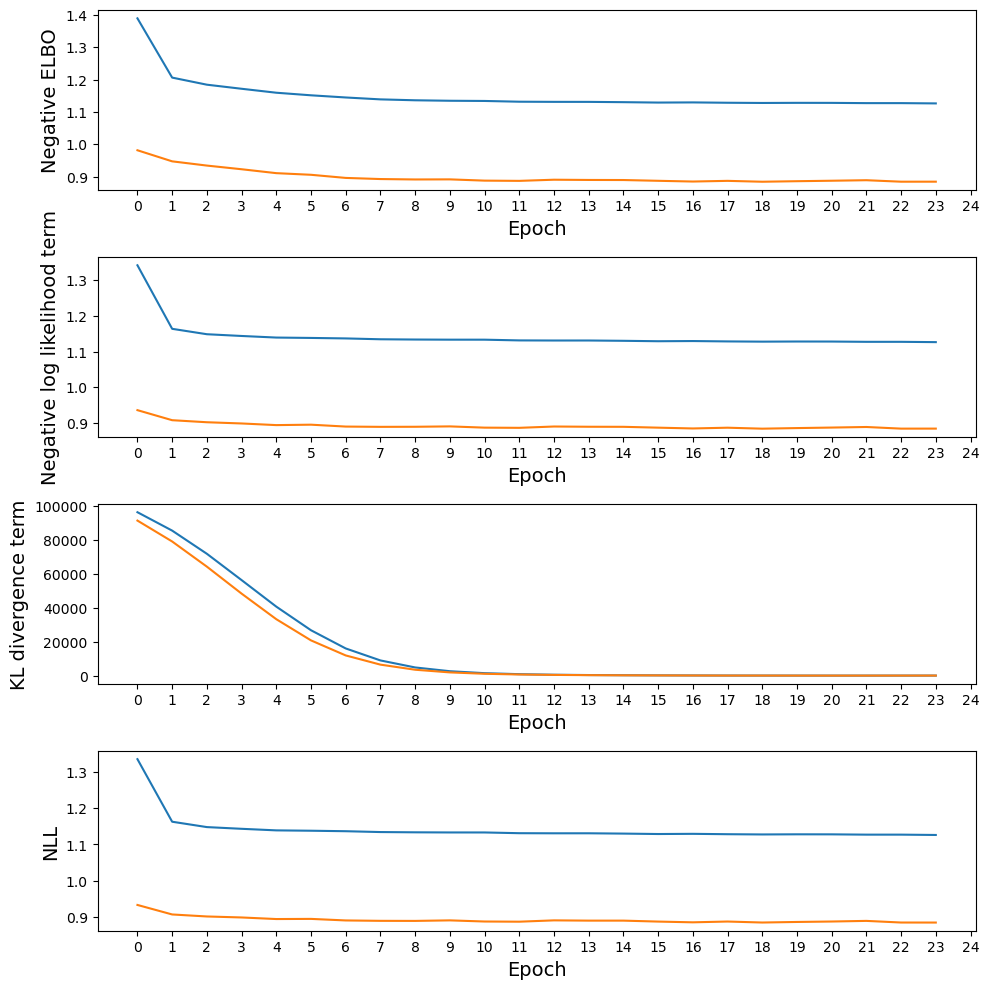

In [85]:
train_vars = [train_loss, train_loglik, train_kl, train_nll] 
validation_vars = [val_loss, val_loglik, val_kl, val_nll]

labels = ['Negative ELBO','Negative log likelihood term','KL divergence term','NLL']

fig, axes = plt.subplots(4,1, figsize=(10,10))
for i,ax in enumerate(axes.flatten()):
    ax.plot(train_vars[i], label='train')
    ax.plot(validation_vars[i], label='val')
#     ax.set_title(f'{labels[i]} | best: {np.min(train_vars[i]):.2f}')
    ax.set_ylabel(f'{labels[i]}', fontsize=14)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_xticks(np.arange(0, num_epochs))
#     ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [33]:
# test_dataloader = DataLoader(dataset=UpperIndusGridDataset(root_folder, train_mean, train_var), batch_size=1, shuffle=True)

inducing_points = True

model.eval()

# n = val_dataloader.dataset.n
        
start = time.time()

with torch.no_grad():

    for i, (inputs, aux_inputs) in enumerate(dataloader_map):
        
        inputs = inputs.permute(0,2,1).to(device)
        og_inputs = inputs.to('cpu')
#         pdb.set_trace()
        inputs, outputs = forward_backward_pass(inputs, None, n, model, optimizer, q, f, x_ind, 
                                                inducing_points=True, backward=False, f_marginal=f_marginal_flag, n_samples=1, test_time=True)

# model.eval()

# with torch.no_grad():
    
#     for index, (inputs, aux_inputs) in enumerate(dataloader_map):
        
#         inputs = inputs[:,:,:].to(device)
#         aux_inputs = aux_inputs[:,:,:].to(device)
        
#         b = inputs.shape[0]
        
#         if index == 0:
        
#             q.build_normal()

#             x = inputs[0,:2,:].permute(1,0).float()
            
#             inputs = inputs[:,2:,:]
#             aux_inputs = aux_inputs[:,:,:].to(device)

#             # Sample z and concatenate to inputs
#             if inducing_points:
                
#                 #f_sample = f_post(x).sample(b).permute(1,0).unsqueeze(1)
                
#                 f_post = f | (f(x_ind), q.sample())
                
#                 if f_marginal_flag:
#                     f_sample = Normal(f_post.mean(x),
#                                       Diagonal(f_post.kernel.elwise(x)[:, 0])
#                                       ).sample().permute(1,0).unsqueeze(1)
#                 else:
#                     f_sample = f_post(x).sample().permute(1,0).unsqueeze(1)
                
#                 inputs = torch.cat([f_sample, inputs], dim=1)
                 
#             else:
#                 q_sample = q.sample(b).permute(1,0).unsqueeze(1)
                
#                 inputs = torch.cat([q_sample, inputs], dim=1)

#             # Masking for missing data
#             inputs = inputs.permute(0,2,1)
#             aux_inputs = aux_inputs.permute(0,2,1)
 
#             mask = ~torch.any(inputs.isnan(),dim=2)
#             k = mask.sum()

#             # Forward pass
#             pdb.set_trace()
#             outputs = model(inputs[mask].float())

In [58]:
# inputs = inputs.permute(0,2,1)
print(inputs.squeeze()[:,:].max(0).values)
print(inputs.squeeze()[:,:].min(0).values)

tensor([ 2.4410,  0.6634, -1.2495,  7.1965,  2.3728,  1.4982,  4.3120,  1.7508,
        12.3823,  5.7670,  0.8823,  2.1999,  2.1694,  2.2870], device='cuda:0')
tensor([-4.4332,  0.6634, -1.2495, -6.0376, -1.2919,  0.1193, -3.0267, -0.3101,
        -0.4425, -1.5427,  0.2010, -1.4169, -0.9190, -1.1559], device='cuda:0')


In [67]:
col_names = ['X','Y','wrf_prcp',
#              'doy_sin','doy_cos',
             'GPsample','pi','alpha','beta']
#col_names = ['X','Y','Z','wrf_prcp','doy_sin','doy_cos','GPsample','alpha','beta']

data = np.concatenate([og_inputs.squeeze().permute(1,0).cpu().numpy()[:,:2],
                       inputs.squeeze().cpu().numpy()[:,9:10], #* np.sqrt(train_var[9:10]) + train_mean[9:10],
                       np.expand_dims(inputs.squeeze().cpu().numpy()[:,0], axis=1),
                       outputs.squeeze().cpu().numpy()], axis=1
                       )

# pdb.set_trace()

df = pd.DataFrame(data, columns=col_names)

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.X, df.Y))

gdf['uniform'] = gdf.apply(lambda x: np.random.uniform(0,1),axis=1)
#gdf['uniform'] = np.random.uniform(0,1)

gdf['sample'] = gdf.apply(sample_apply, axis=1)

gdf['uniform'] = gdf.apply(lambda x: 0.5, axis=1)
gdf['bg_median'] = gdf.apply(sample_apply, axis=1)

gdf['g_mean'] = gdf['alpha']/gdf['beta']

gdf['p'] = 1 - gdf['pi']

x_ind_plot = x_ind.detach().cpu().numpy() * np.sqrt(train_var[:2]) + train_mean[:2] 
x_val_plot = val_stations * np.sqrt(train_var[:2]) + train_mean[:2] 

In [68]:
st_stations = st.groupby('Station').mean()[['X','Y']] * np.sqrt(train_var[:2]) + train_mean[:2]

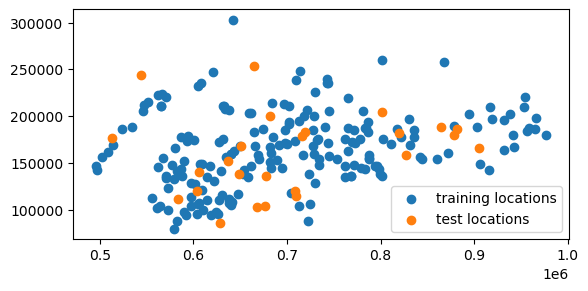

In [69]:
gdf_stations = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(x_ind_plot[:,0], x_ind_plot[:,1]))
gdf_val_stations = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(x_val_plot[:,0], x_val_plot[:,1]))

plt.figure()
gdf_stations['q_sample'] = q.sample().detach().cpu().numpy()
plt.scatter(x_ind_plot[:,0],x_ind_plot[:,1], label='training locations')
plt.scatter(x_val_plot[:,0],x_val_plot[:,1], label='test locations')
# gdf_stations.plot('q_sample', cmap='viridis')
# gdf_val_stations.plot()
plt.gca().set_aspect('equal')
plt.legend()
plt.show()

# plt.plot(gdf_stations['geometry'].x, gdf_stations['q_sample'], 'o')

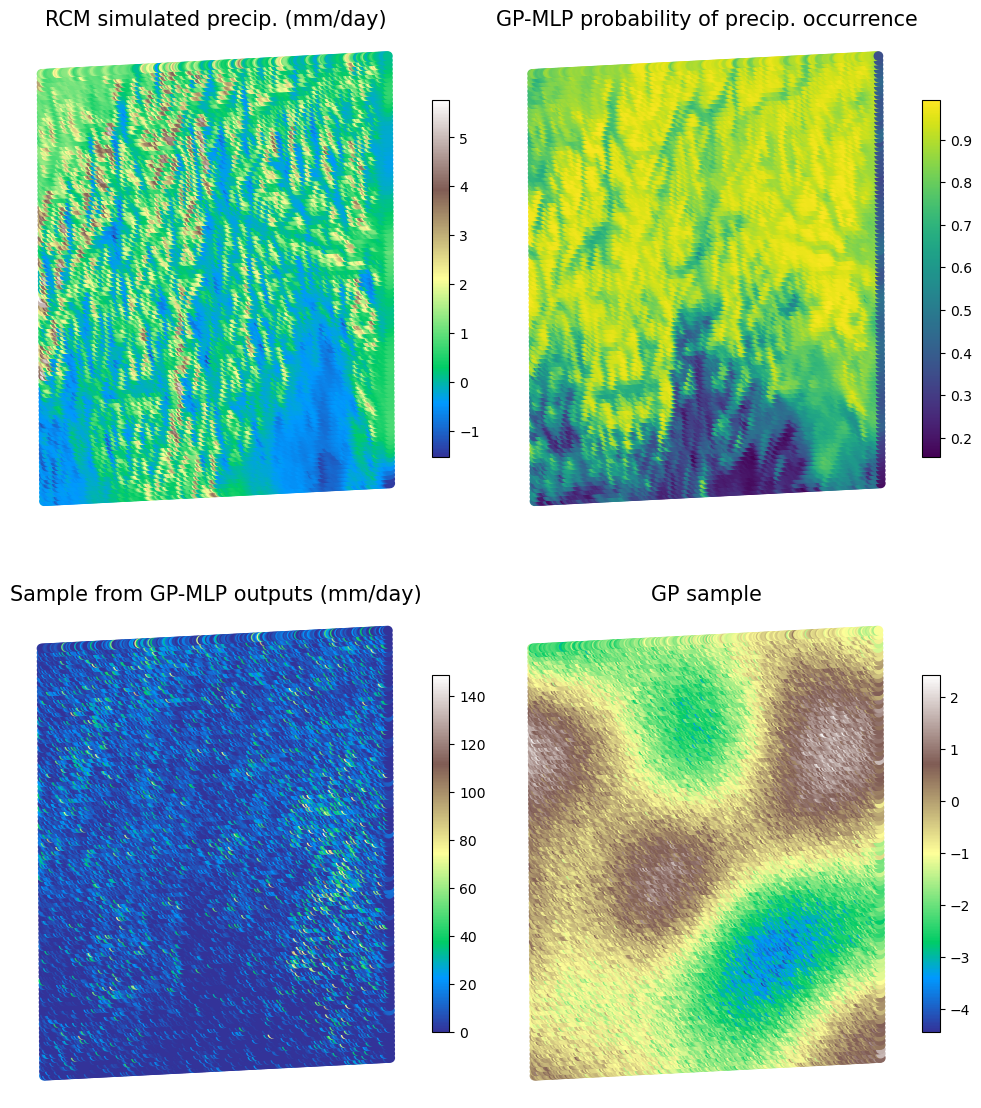

In [76]:
variables = ['wrf_prcp',
             'p',
#              'g_mean',
#              'bg_median',
#              'Z',
             'sample',
             'GPsample'
            ]

labels = ['RCM simulated precip. (mm/day)', 
          'GP-MLP probability of precip. occurrence',
#           '(c) GP-MLP Gamma mean precip. (mm/day)',
#           '(d) GP-MLP median precip. (mm/day)',
#           'Elevation (m.a.s.l.)',
          'Sample from GP-MLP outputs (mm/day)', 
          'GP sample'
         ]

cmaps = ['terrain',
         'viridis',
         'terrain',
         'terrain',
#          'viridis',data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAkwAAAEjCAYAAADALl7RAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjUuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/YYfK9AAAACXBIWXMAAA9hAAAPYQGoP6dpAAByIklEQVR4nO3deVxU5f4H8M8MwrAIA0gwoKSkiRLupqIW5gYuqC3X0iSpLt1yy9Qyb7er1s2lXNOyX2ZaanK7GaVphEtqKAgipIRbBi45SCIMirLInN8f4xxnhpk558ycWfm+Xy9fxczDzDNnhjnf8zzf5/tIGIZhQAghhBBCTJI6ugOEEEIIIc6OAiZCCCGEEA4UMBFCCCGEcKCAiRBCCCGEAwVMhBBCCCEcKGAihBBCCOFAARMhhBBCCIcWju6As1Or1bhy5Qr8/f0hkUgc3R1CCCGE8MAwDG7cuIGIiAhIpdaPD1HAxOHKlSuIjIx0dDcIIYQQYoFLly6hTZs2Vj8OBUwc/P39AWgOeEBAgIN7QwghhBA+qqurERkZyZ7HrUUBEwftNFxAQAAFTIQQQoiLESudhpK+CSGEEEI4UMBECCGEEMKBAiZCCCGEEA6Uw0SIk2pUM8gtuY7yG7UI9fdGn6hgeEiptAUhhDgCBUyEOKGMIiUW7iyGUlXL3hYu98b8pBgkxoY7sGeEENI80ZQcIU4mo0iJV7Yc1wuWAKBMVYtXthxHRpHSQT0jhJDmiwImQpxIo5rBwp3FYIzcp71t4c5iNKqNtSCEEGIrggKmdevWoWvXrmxNori4OPz444/s/QzDYMGCBYiIiICPjw8GDRqE3377Te8x6urqMH36dISEhMDPzw9jxozB5cuX9dpUVlYiOTkZcrkccrkcycnJqKqq0mtz8eJFJCUlwc/PDyEhIZgxYwbq6+v12pw8eRLx8fHw8fFB69at8c4774Bh6ERDnFduyfUmI0u6GABKVS1yS67br1OEEEKEBUxt2rTBkiVLcOzYMRw7dgyDBw/G2LFj2aDo/fffx4oVK7B27Vrk5eVBoVBg2LBhuHHjBvsYM2fORHp6OtLS0pCVlYWbN29i9OjRaGxsZNtMnDgRhYWFyMjIQEZGBgoLC5GcnMze39jYiFGjRqGmpgZZWVlIS0vD9u3bMXv2bLZNdXU1hg0bhoiICOTl5WHNmjVYtmwZVqxYYfHBIsTWym+YDpYsaUcIIUQkjJWCgoKYzz77jFGr1YxCoWCWLFnC3ldbW8vI5XLmk08+YRiGYaqqqhhPT08mLS2NbfPnn38yUqmUycjIYBiGYYqLixkATE5ODtsmOzubAcCcPn2aYRiG2b17NyOVSpk///yTbbNt2zZGJpMxKpWKYRiG+fjjjxm5XM7U1taybRYvXsxEREQwarWa9+tTqVQMAPZxCbGlI79fY9rO/YHz35Hfrzm6q4QQ4tTEPn9bnMPU2NiItLQ01NTUIC4uDiUlJSgrK8Pw4cPZNjKZDPHx8Thy5AgAID8/Hw0NDXptIiIiEBsby7bJzs6GXC5H37592Tb9+vWDXC7XaxMbG4uIiAi2TUJCAurq6pCfn8+2iY+Ph0wm02tz5coVlJaWmnxddXV1qK6u1vtHiL30iQpGuNwbpooHSKBZLdcnKtie3SKEkGZPcMB08uRJtGzZEjKZDC+//DLS09MRExODsrIyAEBYWJhe+7CwMPa+srIyeHl5ISgoyGyb0NDQJs8bGhqq18bweYKCguDl5WW2jfZnbRtjFi9ezOZOyeVyREZGmj8ghIjIQyrB/KQYAGgSNGl/np8UQ/WYCCHEzgQHTNHR0SgsLEROTg5eeeUVTJ48GcXFxez9hpvcMQzDufGdYRtj7cVow9xN+DbXn3nz5kGlUrH/Ll26ZLbvhIgtMTYc6yb1hELurXe7Qu6NdZN6Uh0mQghxAMGFK728vNChQwcAQO/evZGXl4fVq1dj7ty5ADSjN+Hh977Qy8vL2ZEdhUKB+vp6VFZW6o0ylZeXo3///mybq1evNnnev/76S+9xjh49qnd/ZWUlGhoa9NoYjiSVl5cDaDoKpksmk+lN4xHiCImx4RgWo6BK34QQ4iSsrsPEMAzq6uoQFRUFhUKBPXv2sPfV19fj4MGDbDDUq1cveHp66rVRKpUoKipi28TFxUGlUiE3N5dtc/ToUahUKr02RUVFUCrvFfDLzMyETCZDr1692DaHDh3SKzWQmZmJiIgItGvXztqXTYjNeUgliGvfCmO7t0Zc+1YULBFCiCMJyRCfN28ec+jQIaakpIQ5ceIE889//pORSqVMZmYmwzAMs2TJEkYulzPffvstc/LkSWbChAlMeHg4U11dzT7Gyy+/zLRp04bZu3cvc/z4cWbw4MFMt27dmDt37rBtEhMTma5duzLZ2dlMdnY206VLF2b06NHs/Xfu3GFiY2OZIUOGMMePH2f27t3LtGnThpk2bRrbpqqqigkLC2MmTJjAnDx5kvn222+ZgIAAZtmyZYKy4mmVHCGEEOJ6xD5/CwqYXnjhBaZt27aMl5cXc9999zFDhgxhgyWGYRi1Ws3Mnz+fUSgUjEwmYx599FHm5MmTeo9x+/ZtZtq0aUxwcDDj4+PDjB49mrl48aJem4qKCubZZ59l/P39GX9/f+bZZ59lKisr9dpcuHCBGTVqFOPj48MEBwcz06ZN0yshwDAMc+LECeaRRx5hZDIZo1AomAULFggqKcAwFDARQgghrkjs87eEYaj0tTnV1dWQy+VQqVQICAhwdHcIIYQQwoPY52/aS44QQgghhAMFTIQQQgghHChgIoQQQgjhQAETIYQQQggHCpgIIYQQQjhQwEQIIYQQwoECJkIIIYQQDhQwEUIIIYRwoICJEEIIIYQDBUyEEEIIIRwoYCKEEEII4UABEyGEEEIIBwqYCCGEEEI4UMBECCGEEMKBAiZCCCGEEA4UMBFCCCGEcKCAiRBCCCGEAwVMhBBCCCEcKGAihBBCCOFAARMhhBBCCAcKmAghhBBCOFDARAghhBDCgQImQgghhBAOFDARQgghhHCggIkQQgghhEMLR3eAEEKIfTSqGeSWXEf5jVqE+nujT1QwPKQSR3eLEJdAARMhhDQDGUVKLNxZDKWqlr0tXO6N+UkxSIwNd2DPCHENNCVHCCFuLqNIiVe2HNcLlgCgTFWLV7YcR0aR0kE9s49GNYPs8xX4vvBPZJ+vQKOacXSXiAuiESZCCHFjjWoGC3cWw1iIwACQAFi4sxjDYhRuOT1HI2tELDTCRAghbiy35HqTkSVdDAClqha5Jdft1yk7ae4ja0RcFDARQogbK79hOliypJ2r4BpZAzQjazQ9R/iigImQ5kTdCJT8Apz8RvNfdaOje0RsLNTfW9R2rqI5j6wR26AcJkKai+IdQMZcoPrKvdsCIoDEpUDMGMf1i9hUn6hghMu9UaaqNTraIgGgkGtKDLiT5jqyRmyHRpgIaQ6KdwBfP6cfLAFAtVJze/EOx/SL2JyHVIL5STEANMGRLu3P85Ni3C7hu7mOrBHboYCJEHenbtSMLJnL5sh4k6bn3FhibDjWTeoJhVw/OFDIvbFuUk+3XC2mHVkzFQZKoFkt524ja8R2BAVMixcvxsMPPwx/f3+EhoZi3LhxOHPmjF6blJQUSCQSvX/9+vXTa1NXV4fp06cjJCQEfn5+GDNmDC5fvqzXprKyEsnJyZDL5ZDL5UhOTkZVVZVem4sXLyIpKQl+fn4ICQnBjBkzUF9fr9fm5MmTiI+Ph4+PD1q3bo133nkHDENJfqQZuXCk6ciSHgao/lPTjritxNhwZM0djG2p/bD6me7YltoPWXMHu2WwBDTfkTViO4ICpoMHD2Lq1KnIycnBnj17cOfOHQwfPhw1NTV67RITE6FUKtl/u3fv1rt/5syZSE9PR1paGrKysnDz5k2MHj0ajY33rnAnTpyIwsJCZGRkICMjA4WFhUhOTmbvb2xsxKhRo1BTU4OsrCykpaVh+/btmD17Ntumuroaw4YNQ0REBPLy8rBmzRosW7YMK1asEHSQCHFpN6+K284BqPCgODykEsS1b4Wx3Vsjrn0rtw8WmuPIGrEdCWPFcMtff/2F0NBQHDx4EI8++igAzQhTVVUVvvvuO6O/o1KpcN9992Hz5s14+umnAQBXrlxBZGQkdu/ejYSEBJw6dQoxMTHIyclB3759AQA5OTmIi4vD6dOnER0djR9//BGjR4/GpUuXEBERAQBIS0tDSkoKysvLERAQgHXr1mHevHm4evUqZDIZAGDJkiVYs2YNLl++DImE+8uiuroacrkcKpUKAQEBlh4q0gw47T5dJb8AX4zmbjf5ByDqEdv3RyAqPEis5bR/m8SmxD5/W5XDpFKpAADBwfpzwAcOHEBoaCg6duyI1NRUlJeXs/fl5+ejoaEBw4cPZ2+LiIhAbGwsjhzRTAlkZ2dDLpezwRIA9OvXD3K5XK9NbGwsGywBQEJCAurq6pCfn8+2iY+PZ4MlbZsrV66gtLTU6Guqq6tDdXW13j9CuGQUKTFw6X5MWJ+DV9MKMWF9DgYu3e8chfHa9teshjOXzRHQWtPOyVDhQSKG5jayRmzD4oCJYRjMmjULAwcORGxsLHv7iBEjsHXrVuzfvx/Lly9HXl4eBg8ejLq6OgBAWVkZvLy8EBQUpPd4YWFhKCsrY9uEhoY2ec7Q0FC9NmFhYXr3BwUFwcvLy2wb7c/aNoYWL17M5k3J5XJERkbyPiakeXL6k7rUQ1M6AIDJbI7EJZp2ToQKDxJCnInFAdO0adNw4sQJbNu2Te/2p59+GqNGjUJsbCySkpLw448/4uzZs9i1a5fZx2MYRm+KzNh0mRhttDOQpqbj5s2bB5VKxf67dOmS2X43K1T0sAmXOanHjAHGfwkEGExhBURobnfCOkxUeJAQ4kwsKlw5ffp07NixA4cOHUKbNm3Mtg0PD0fbtm1x7tw5AIBCoUB9fT0qKyv1RpnKy8vRv39/ts3Vq00TUP/66y92hEihUODo0aN691dWVqKhoUGvjeFIknZ60HDkSUsmk+lN4ZG7qOihUUJO6nHtW9mvY8bEjAE6jdKshrt5FWgZppmGc7KRJS0qPEgIcSaCRpgYhsG0adPw7bffYv/+/YiKiuL8nYqKCly6dAnh4Zor2169esHT0xN79uxh2yiVShQVFbEBU1xcHFQqFXJzc9k2R48ehUql0mtTVFQEpfLedEdmZiZkMhl69erFtjl06JBeqYHMzExERESgXbt2Ql5680ZFD01yuZO61EOT2N3lKc1/nTRYAqjwICHEuQgKmKZOnYotW7bgq6++gr+/P8rKylBWVobbt28DAG7evIk5c+YgOzsbpaWlOHDgAJKSkhASEoLHH38cACCXy/Hiiy9i9uzZ2LdvHwoKCjBp0iR06dIFQ4cOBQB07twZiYmJSE1NRU5ODnJycpCamorRo0cjOjoaADB8+HDExMQgOTkZBQUF2LdvH+bMmYPU1FQ2G37ixImQyWRISUlBUVER0tPTsWjRIsyaNYvXCjkCKnrIgU7qtkOFBwkhzkRQwLRu3TqoVCoMGjQI4eHh7L///ve/AAAPDw+cPHkSY8eORceOHTF58mR07NgR2dnZ8Pf3Zx9n5cqVGDduHMaPH48BAwbA19cXO3fuhIfHvavdrVu3okuXLhg+fDiGDx+Orl27YvPmzez9Hh4e2LVrF7y9vTFgwACMHz8e48aNw7Jly9g2crkce/bsweXLl9G7d29MmTIFs2bNwqxZsyw+YM0OFT00i07qtuOowoNU84kQYoxVdZiag2Zfh+nkN8D2F7nbPblBM83TDGlXyQH643Da0zgVyBNOt25O6bVb2JZ7EWXVtq/DRDWfCHEfYp+/LUr6Js1IS+PJ8Ra3c0PaasKGJ1oFnWgtYixoUQTI8NrQB9EuxM9mhQe1ga/hFaS2PAQFvoQ0bzTCxKHZjzCpG4FVsZoEb6N5TBLNarmZJ506gdgeqJqw9UwFLbYerWtUMxi4dL/JFY8SaALgrLmD6T0lxEU4VaVv0gy4aNFDMQjNZaFqwtZxZE0rqvlECOFCU3KEm7boodE6TEvcsg4T5bLYnyNrWrlceQhCiN1RwET4cbGih9agXBbHcGTQwrfsQ+m1W6I/NyHENdCUHOHPhYoeWqr+jhr/TD/p/FuduCFH1rTq1TYIfGZQt+VeoPeekGaKAiZC7sooUqLf4n24XtNgsg3lstiOI2ta5V+oBJ84qKy6jt57QpopCpgIwb1puOs19dyNQbkstuCoQpWAsPeT3ntCmicKmEizZ251lim01YltaGtaKeT6x1ch97Zp7piQ95Pee0KaJ0r6Js0e1+osXdp6PLTVie0kxoZjWIzCrjWt+kQFQxHgrVdN3BhFgIzee0KaKQqYSLMndIrFVtNC5B5tTSt7Pt+CMTF4+e4WN6YsGPMQvfeENFM0JUeaPb5TLMF+nlRSwAXxLUCaGBuOTyb1RKCvZ5P7An098Qm994Q0azTCRJo97eqsMlWtyTymVn5eyJ43BF4t6BrDlQgtQKqdDsz5owLZ5ysAMIh7IAT9qHI7Ic0e7SXHodnvJWdjzrL/mnaVHKC/Y56t9zAjtuOofekIIc5B7PM3jTARu9INkEqv3cK23It6ibaO2n5EuzrLcDRCQduhuCSufekk0BQgHRajoJEjQggvFDARuzE2PWLIkduPOGJ1FrENR+5LRwhxTxQwEbswNT1iSHv/m9+ehL/M0+65I/ZenUVsgzbTJURczpI+4UgUMBGbs6QwZNWtBjy74ajDpuiIa3PkvnTG0MmGuDKhiyfcFQVMxOaEFIY05MgpOuK6uFY+2rMAKZ1siCszNTvQHL+baY00sTlrpj20f6QLdxbTLvGEN0fuS6dLe7IxvGDQnmwyipQ2fX5CrMG1eAJoXt/NFDARm7N22kM3QZcQvhy1L50WnWyIqxOyeKI5oCk5IgpzORp8CkPyQQm6RChHrnyklXrE1dHiCX0UMBGrceVoaKdHXtlyHBLA4qCJdol3Hq6UxOyolY90siGuztkWTzgaBUzEKnwTAk0WhgyQ4ZmH78emI6Wout1g9DnsmaBLuFmSxOxKAZZY6GRDXJ0zLZ5wBhQwEYs0qhnk/FGBN7ef5F1N2dz0SKdwf7Nbk9gjQZdws2TFTHNdJUYnG+LqzM0ONMfvZtpLjgPtJdcUn4rdural9jM6JVJ/R43N2aW4cP0W2gb7Isxfhvd+PO32J1ZtsOlqm7s2qhkMXLrf5PuuDQCy5g5mX4u5/dwYAK8NfRDtQvzcdtSJ9igk7sBVL3poLzniUHwrdusylqOxeHcx1v9SAt0FQlIJ8OLAKAzuFOa2UzcZRUq8+e1JVN26N/249ufzCPT1xJInujj1l4/QJGY+q8RW7j3H3uYKX8BC0R6FxBrOMpU9LEYBf29Pl7vIExsFTIQ3Syp2A01zNBbvLsb/HSpp0k7NAOt/KYFUAswbGWNFT51TRpESL98dbTBUdasBL285jk+ceMRBaBKz0IKl7loIj/YoJJZwllEdY/3YfvzPZhnwUx0mwpvQE6AEmj9w3RyN+jtqrP+labCka/0vJai/o7a0m06pUc1gwY5iznYLdvzmtHV5hCYxC1395c61ibQr9cZ2b424ZnhlToRxloKnztIPZ0EBE+FNyAnQVELg5uxScJ0L1YymnTvJLbmOsmru41dWXYeVe84i+3yF0wUN2iRmU6d6wwDZktVflhTCa1QzyD5fge8L/3TK40aIEM5S8NRZ+uFMaEqO8CbkBGgqR+PC9Vu8fp9vO1chJNhc+/PvWPvz706X0yN0xYw1BUv5Hi9bTls4S/6Is/SD2IezFDx1ln44EwqYCG99ooIR6Oupl7BsKNDXEx9N6GkyIbBtsC+v5+LbzlVYMtrijDk9QpKYrSlYyud42XJTUGfOH7GqH+pG4MIR4OZVoGUY0LY/IPUQscfEWs5S8NRZ+uFMKGAivO0pLjMbLAHAkie6YMCDISbvT45rh/d2nzI7LSeVaNq5kz5RwVAEePOaltMyVstKCO3IRJnqNq7X1CO4pQyKAOtHKIQkMZsKsEzhW5uIa7rAmuPmLLuzi96P4h1Axlyg+sq92wIigMSlQMwYUfpMrOcsBU+dpR/OhAImwov2BGVOkK8nhsUozLbxaiFF6iNRRlfJaaU+EgWvFu6VXuchlWDBmBiTq+RMsXTY21ytLDFGSoRsN2IYYJVeu4VVe88CsLwQnq2mC2wZiAkhej+KdwBfP4cm43zVSs3t47+koMlKYk2d2rLgqZA+UuHVpihgIrzwWSFXeauB1wlKWzLAWB2m1Eei3LKkAKAJHF4b2hEr7wYLQggZ9uaqlaV0wFSfYYAVrWhpVW0iW00XOEvehqj9UDdqRpbMhV8ZbwKdRtH0nIXEnDq1VXVtoX2kKt9NUcBEeBH7BDVvZAxmD++kV+k7Oa6d240sGZo2uAO25V5AWXWdoN/jO+wtpFaWRSMlIuXAWFubKKSljHe77PMVvJ/DWfI2RO3HhSP603BNMED1n5p2UY/w6yBh2WIKV+yCp5b2kQqv6hN0dlq8eDEefvhh+Pv7IzQ0FOPGjcOZM2f02jAMgwULFiAiIgI+Pj4YNGgQfvvtN702dXV1mD59OkJCQuDn54cxY8bg8uXLem0qKyuRnJwMuVwOuVyO5ORkVFVV6bW5ePEikpKS4Ofnh5CQEMyYMQP19fV6bU6ePIn4+Hj4+PigdevWeOedd0C7wQhni/lsrxZSvPjIA3hnbCxefOQBtw+WAO3U3EOQACaX5+syVsvKHL61sixZvo/iHcCqWOCL0cD2FzX/XRWrud0CltYmyihSYvbXhWbbSKCZIp79dSEmrM/Bq2ma/w5cut9s7RhnydsQtR83r/J7Ur7tCMuWS+8TY8ORNXcwtqX2w+pnumNbaj9kzR0sOEixto9i9cMdCDpDHTx4EFOnTkVOTg727NmDO3fuYPjw4aipqWHbvP/++1ixYgXWrl2LvLw8KBQKDBs2DDdu3GDbzJw5E+np6UhLS0NWVhZu3ryJ0aNHo7GxkW0zceJEFBYWIiMjAxkZGSgsLERycjJ7f2NjI0aNGoWamhpkZWUhLS0N27dvx+zZs9k21dXVGDZsGCIiIpCXl4c1a9Zg2bJlWLFihUUHqzkTWoOHmKa9alPIzZ/sLBn2Fjrywbu9NgfGcKRCmwNjYdAklPZK2dwInXb6oPJWQ5N2XAX3nOVzLmo/Wobxe1K+7QhLyNSpJcQoeCpGH4X2w11rowmaksvIyND7eePGjQgNDUV+fj4effRRMAyDVatW4a233sITTzwBAPjiiy8QFhaGr776Cv/4xz+gUqmwYcMGbN68GUOHDgUAbNmyBZGRkdi7dy8SEhJw6tQpZGRkICcnB3379gUArF+/HnFxcThz5gyio6ORmZmJ4uJiXLp0CREREQCA5cuXIyUlBe+99x4CAgKwdetW1NbWYtOmTZDJZIiNjcXZs2exYsUKzJo1CxJJ85l7tRbNZ4vLWCL0ttyLeqvoLBn2Fjrywau9k+TA8J1uVMi9cbuh0eiKTq6EaWf5nIvaj7b9NavhqpUw/h5KNPe37W91v3U1h/pR9prCteZY2nua2VlKctiCVXMgKpUKABAcrLnKKSkpQVlZGYYPH862kclkiI+Px5EjRwAA+fn5aGho0GsTERGB2NhYtk12djbkcjkbLAFAv379IJfL9drExsaywRIAJCQkoK6uDvn5+Wyb+Ph4yGQyvTZXrlxBaWmp0ddUV1eH6upqvX9Ew9TIiELu7VS1glyF7lXbq0MfxOE3rR/21o5McBE0QiEkB8aG+E43vjCgndnyF1xX1M7yORetH1IPTekAAE0ngu/+nLhE1GA3o0iJgUv3C5oOdUX2mMK15FjqjvBcu8EvX1KMaWZ330rF4qRvhmEwa9YsDBw4ELGxsQCAsrIyAEBYmP7QblhYGC5cuMC28fLyQlBQUJM22t8vKytDaGhok+cMDQ3Va2P4PEFBQfDy8tJr065duybPo70vKiqqyXMsXrwYCxcu5D4AzRRtJGo7Qpbqm3sM7cgE10gM7xEKB+fAaK+uf+T5ZXup8javduauqJ3lcy5aP2LGaEoHGK3DtETUkgLOUsfKHmy99N6SY2lshEcqgcnad2KVB3CWkhy2ZHHANG3aNJw4cQJZWVlN7jOc6mIYhnP6y7CNsfZitNEmfJvqz7x58zBr1iz25+rqakRGRprte3Mjxomd2A5XsUjBw+M2yoHhM81grp6UKXyrxHNdUTvL59xYPyyaookZo5k2tWGl7+Zw0tRlyylcS46lqQDLXLBkTR91OUtJDluyKGCaPn06duzYgUOHDqFNmzbs7QqFpmhhWVkZwsPvfRmXl5ezIzsKhQL19fWorKzUG2UqLy9H//792TZXrza9Wv3rr7/0Hufo0aN691dWVqKhoUGvjXa0Sfd5gKajYFoymUxvCo8QV6Q7MmF1pW8b5MDwyXPgqidlpBdQyL2RHNcOn2WVuG3BPatyRKQeNi0d0BxOmoZstfRe6LHkk+NnONIkZnkAZynJYUuCcpgYhsG0adPw7bffYv/+/U2mtKKioqBQKLBnzx72tvr6ehw8eJANhnr16gVPT0+9NkqlEkVFRWybuLg4qFQq5Obmsm2OHj0KlUql16aoqAhK5b1h+szMTMhkMvTq1Yttc+jQIb1SA5mZmYiIiGgyVUeIu9GOTDzesw1efOQBPN7DwpU2IufAmMpzUOrkOQipJ6Xbq/lJMfBqIcX8pBhzvXXZBQrOniPSHE6axthi6b3QY8knx0/NAG+P6myT8gDOUpLDlgQFTFOnTsWWLVvw1Vdfwd/fH2VlZSgrK8Pt25qcAYlEgpkzZ2LRokVIT09HUVERUlJS4Ovri4kTJwIA5HI5XnzxRcyePRv79u1DQUEBJk2ahC5durCr5jp37ozExESkpqYiJycHOTk5SE1NxejRoxEdHQ0AGD58OGJiYpCcnIyCggLs27cPc+bMQWpqKgICAgBoShPIZDKkpKSgqKgI6enpWLRoEa2QI0QobQ5MgMGXa0CEoG01uAIhBppphpw/KgRNwxkmQjtL4raYbFnzRyzN4aRpihglAHQJPZZ8A6wQf5lofdTlLCU5bEnQlNy6desAAIMGDdK7fePGjUhJSQEAvPHGG7h9+zamTJmCyspK9O3bF5mZmfD392fbr1y5Ei1atMD48eNx+/ZtDBkyBJs2bYKHx70r1K1bt2LGjBnsaroxY8Zg7dq17P0eHh7YtWsXpkyZggEDBsDHxwcTJ07EsmXL2DZyuRx79uzB1KlT0bt3bwQFBWHWrFl6OUqEEJ5EyIHhcxWsVNUi+3wFr8d7Lq4tRsSGG51mdJbEbbG4wnSXq+8/5kylEIQeS0cHq85SksOWJAyVvTaruroacrkcKpWKHblyR870RUHcV/rxy3jt6185200d1B4fHTjP2W5baj/RggNn/xv4vvBPvJpWyNlu9TPdMbZ7a9t3yATttCFg/KRptxE+gdv42Lp+kCWfLyHHslHNYODS/ZwBVtbcwTb9XDtTHSaxz9+0lxxxqg84cW/Xa+q5GwEI9PW060iFM54sDfHdP8/R011Osf9Y8Q4TJRSWGp0+tnUpBEs/X0KOpb1HeEx9pt1tZFcXjTBxcPURJq4valNfFHa/GiROw5YjLekFf+K1/xZytlv5dHf4eErtMlJh678BMYKxjCIl3tx+AlW375hsY+sRBKGfC4eN2Gm38TH1jhrk3GlHZgynO6VQo4/0NEJRhTt+oVgzdyo8WggfYxDj8yXkWNrjAtjcczhTsCT2+ZsCJg6uHDBx/eGY+qLQstcQLnEetvyybVQz2HS4BO/uOsXZVjvVZk1/+JxkbP03wHWy/GhiTwT5eXHWonr5buBojgS2u8AR63Nh8yBK3ajZENpkZfq7JTBmnmSn57LPV2DC+hy9VgnSXMz3/BIRknvV4Ot8FZCN/kBQkU9Hfcfa8jib+0wz0IwO61bad+RsBQVMduaqAROfqxq5j1eTLwpjxMwTIc7LliMtQgpQhhucQCzN/eBzgjd2sjTGkr8BrpMl0LQujmEfG9UMBizZZ3azYe3jrJ3QAyO7RphtZwmxPhd2mfov+QX4YjR3u8k/sPWoDHPDEqS5WOe5CoDmuGoxkGhes4BVobb8fDmC5vO4X2/PSy6OnK0Q+/xt1V5yxDnxXX7M90PvbjVTmjNTu4jbcsm6qdpBhiR3/xnmWZhcrq1u1JwgT36j+a+60ezzGatVZMu6QXzr4pjrY27Jdc5gSfs4QX7iF9wV63Nht/pRFmzjo5vzJYUa8z2/1Py/QUwu0b7ijDfZzxoXd6tLtXb/OUHBEuA8JS/EQEnfbojv8uPrN+23KSNxPHNX+HIfL5ssWRdSgFJQUrCJpN7GhCVYuLMl7+0kbLkU25KToGEfhTzG3uIy0UcpjH2X6Ob2lCMQuapOZj8Xdt0uxYJtfHSX7/eRntabhmtKZ6NpHhXTHb3UX0wZRUqs3HvOot91hpIXYqARJjfE90s22M/L7QuNEQ2uK/w9xWUmflOf0CCAzygLoKk+zLvqsDap1zBPpVoJ6f8mo+uNQyZ/VfeLG7BtsT1LT4K6fRTyGBsOl4pe6dvw/U6Q5iJLNgNpXv/Bh15rkeb1H2TJZsDjzE6TjyGkfpTVtNv4mHtHA1rrbeOjXV0GAKGo4vc8PEey3KWYozbotZarjKSZQgGTG+L7JauQ+7jtFhLkHj7TKt8XmkqS1Sc0CBBSfZjX50zdqBlZMvNq5ntuhhRqXv3SPVmK/TfAdbLkUn6jFn2igqEI4D/VJva0h+77rc3tUUA/sFHgOh7OnakJZI2w67SUhdv4aJfvN/qG8HseniNZtvx8WcvU9LwxfC98uBh+fwjpgzOggMkNCbmqccctJIxxtT9MMfG5wq+oqUewn6foV8KiT0mUZplZAaXJM4mQVKCP9DTv57PV34C5kyUfof7e8JBKsGDMQ7x/R7SRmru03yUeZnJ72J9N5PbYfVrKwm18EqV5WOvzKceDNx2h4uKM37EZRUoMXLofE9bn4NW0QkxYn4OBS/ebHKG0Npg19v0htA/OgHKY3JDQAmbuUmjM1Gqq5l6Yk++X3ePdW+Pzw6W8i97xWb0m6lYZxTuAndN5vRZTUyumns9WfwOmCg8aro4z18fE2HB8MqknZn39K27Vcycbizntof0u2fTVFrO5PRIzuT0O2S5F6DY+d6d5JWaz7YRvNK3lTN+xlhTpFBLM8vn+sHWhUFuhgMlVcZT9F1ptV7sSyVWZCorGdAvHp4dKXO4PU0x8v+yGxijwcFQwr88M3yBUtOrDJosRGleOQMHPZ6u/AWMny8qaOkz9qgDg2cfE2HD4e3vi2c+Ocj6f2AnEibHhCB8YCORyt/311Gl0MwiYtJ8BU7WkGNhoWkrqwSsx2/w0rw7/cGCE8UrhfDjDd6ylCfhcQS8AKAJk+Pfoh/DuLvPfH3ZdBCAyCphcEc+y/850VWNL5q5W/u9QidHfceQfpr0rIAu5wveQSjg/M0KvDq3eKoPvCU37agIikDJsAi78cKbJ8709qjPkPl74vvBPmx97rvd5nVRi8pgMi1Eg+3yF3u/2e6CVKCM1lnz+unXuxCtgWpxVhZT7la51EXLhiNlpXtbjnwAPxNu+PzZk6QbOfC58Fox5CImx4UiINf/94QqbSJtCAZOrMXWlXa3U3G4wR+8MVzW2xCeh2RTtH+amwyUI8ZfZJXhxxPSg0FEec58ZS68OrQre+Z7Q2CdbgsSYNhj2UGu957t2sw7/+v43vf3sbHXs+bzPpo7JnuKyJgUvtb9r7WidxZ+/u6vPmGql0WkrNQOUoRXy1J1wweD951ph5fARBb61m2r+sm0/7MCaBHy+Fz5c5xxXrk1FSd+uhMcKISFF1dyBGKs33t11yi5Jh3Yr3meEWImn1iwRN1mA0oBhgr76Br+SB/AJ1rtg0H2+A2euYvq2giab/yptcOyFvM+Gx2RPcZnZ3wVg8fto1edPZ/WZYe6V9ueFDclohLTJ+2/XsgKWsKB2k6uyNgE/MTYcWXMHY1tqP6x+pju2pfbjXw5EpD44Eo0wuRLOK21hRdXcgdhXIbbIbWpUM8g5X4E3t5906Ly9GFO0tr46NDYCMtL/Cj7m88tPbQTaD2py8+4TV0xOzQKa4y/Wsec7Aje4UxjyL1TqvQ+4ex/X72bNHSz4fRQlbyRmDPL6rEKbowsRoVNaoAytsLAhGT+p+7C36b7/Tj+ioK3dVK2E8YvRu/vPCVgZ56zESMC3dtbCIYsAREIBkyuxoOy/uxP7KkTs4IXvHmr2mre39svOmqtDrtwZU7lRP914AFdkwQiXVJpYxXT3hGbkIqFRzeBf3xdx9tfw2FuaZ8Z3NKXf4r24XnNvg9JgP0/0iwoWlNsh5H0UK2+kMToJAw+10q/0re4EtcFkhe777/QjCtrRs6+fg8k1XhasjHNGoi3CcPE+WIoCJlfSjIaO+eKzekMosYIXUwGAOc44b6/L0qtDY4FjoI8nnh8QhWmDOwAwPbrSCCneaXgO67xW3d0Alf8JLbfkul5gYo722FuTZ8b3/TPs0/WaBuwu4nehY8lnRMgoj7lgsU9UMMLkvjiqiuH9/rvEiIK2dpPRxTRLLF4Z54ysXoThJn2wBAVMroRj6JiBBBI3GTrmy9zVirWsCV6E7KGmyxnn7XXxuTp8e1Rno0voDY9F1e0GrNx7FhuPlOD5/lFmR0Ay1H3wcv1MfBiYBtktnZwmjhOakPcw1N/b6vow9nj/LHkOvr9Teq3GZMJ5Ymy44NEBbfA1MlaBDYdLmzyfU40oCK3d5MKcYQW1M/RBKAnDMM2n5LEFqqurIZfLoVKpEBAQ4OjusKvkNFNH9946NQNIJEBh3IfokTDZcf1zEL5TX0JsS+1n8QhT9vkKTFifw7u99io7a+5gXl8YjWoGuef/QmPpYYRKqtD+gfbwaDeA15e7GGUNzNW92vGrkneRRqFWP90FYwMv8DqhNaoZbDpcgnd3neJ83FZ+XsieNwTxH/xs8jPE5z1qVDMYuHS/qCOeQp7fFK5+SQAE+nqi8lbT0TjtM+kGi3xG4Yy1MfwsNKcCssT+xD5/0wiTq4kZg4K41Qg7skCv8m4ZWuGd+mT89HMI1rV2sTooIjC8Wrl2o47XidIYMaYIhIxsCL3KzihS4sB3n2NGw2f3PgNZwG0fBXySPjA7fWBtWQNtsFV3R41lT3UDJMC1m3V3R5LqMfWrpqMzYu5CExrgx2tBg9AA+t2xsci/UGl1no+tRjytHYnhMzJkqq/G8vq4RgdMjdRpL89fGNAOw2IUTj+i4O7sXRPO1VHA5GIa1QymHG+Dq3UfGk28dHhNEzsw9Ueum9DcqGbwWVaJ4Ct9saYIhEybCJm3zyhS4ruvPsHHnqua3Ce7VQbm6+cgMbFflrXTTeaCrT5RwRi4dL/ooypaQoJYoblj/3g0CiO7huP7wj95tecKhk3lZ7Ty80KFQVkDvsTI7TCXN/LMw/dj5d6zJn/XWLBoagEBnxV5PxaV4a1RTjAN5wgcuzTYS3PfMsoSFDC5mHurXaTIUcc0ud+Zq6SKQcwtOV56NKrJ9JFYSYd8ktEDfTzx0bM90e8B0zWJdDWqGby74yT+Z2YTVDUYIONNSDqN0vsStnZZOVewNXPog6JNh1qzckZI7liwnyf+MzYWI7tGABB3NZexEZhebYMQ/8HPgoL4aY91wIAOIaJd+ZsaGfrhBL/CoHxGTl25krPN8dylwdZcdS83R6OAycU4fU0TG7LFlhxvJHa2yZA0n4BtyZNdMKBDCO/HzC25jsibvyLCy3SBPylgtBaXNScxPsHWRiMJvZZ4beiDSMu7ZHEQy7eQ6dujOiNlQJSg/bKETtUaG4HRfia4aJ/rtWEdRR+FMdYvMYPF5vwdZZbAXRqsYW6qzZX3cnM0CphcjNPXNLERW23JYcutY8RYOqv7xXfu6g2EoorfkxvU4rLmJMYn2Kq6zW/pvinaAGHa4AcxbfCDFgexfF9niL+syWPasj6Mbu7XzKEPYlvuRZRV1xlt64iVY2IGi831O8oszl0aJJpdGgxGhi3BNQpPI4CWo4DJRWi/cMuqaxHs52mytoxT1DSxAWv+yB25n541S2eNffH1kwbye2KDWlzWnMT4BiGBPp5Q3W4wOd0kkdxL+tW7/e5/dQMES98vMbZ+ELs+jLH3URHgjdeGdoTqdj2+K7yit2WLI2rRiBksukTdJXuz0y4NfEbh6+6oeT1WsxsB5IECJhfAd8WPU9U0EZkrD/NbErCZ+uLLVXfCFSYYClxvksMEAGoAkoDWkBjU4rLmJMY3CHl+QBRW7T1r8oT70YSeOFd+AxsPl+qNSIkZIIhxshazPoyp9/FqdS1W7T2LdZN64q1RMU6xUkmsYNEVKjnbfXWYHXZp4DsKv+ypbrwer1mNAPJEAZOTE7Lix9mrpFqjOQ3z365vxOvfnDD6nqshxcKG57DOcxXUjH7it6YWlwQSI1WvrTmJ8Upg9/XEtMEdEK1oyXHCDbdqyo0L17J+xszrNHwca0clhUwjO8vUh1jBojNXcnbI6jA77NLAdxQeEtAIoIUoYHJiXCt+JACC/bzwr1GdoZD7uHUNjeYyzL94dzE+/aXE6NSV1k/qPnilYSbme36ptwlqna/5OkymTmLBfl4Y2z0Cch8vNKoZk7k9L5tJVq661YA9xWW8TrjWBiNcowPa1/nmtydRZVCIMdDX0+LnFcrWuSK2GiWx6v3RWTKf2DIMw16PR+4FlcNHz7QctjrMDhv88h1dv3azzulHAJ0VBUxOjM8XbkVNPRRyH6e5QrUVVxjmt9bi3cX4v0MlvNr+pO6DjnFPo6/HGbbStw+PSt+6Ac3e4jKkF/6Jipp6fH64FJ8fLjV5pT0sRoFAX88mAYiWYdK9rT6PQkYHVEb6qrrVwPvEaG1AYstpZKesoWNkybxHQATiEpcC3R2/F5tDV4fZYYNfIaPwce1bOe0IoDOjgMnJ6K+Kusnrd5wxb8cWnHmY31La91tZdRuf8gyWtPo/GIa49k1rcXHxkEqguq0JkvheaeeWXDcZLAH2WVnDd3RAjBOjGAGJraaRnbKGjpVL5u2RU+Tw1WE23uBX6Ci8K+7l5mgUMDkRS/dDc/W8HSFflu70R27p+23t9KMlAYWjk+6F9NnaE6NYAYktppGdsoaOlUvm7TVa5ujPMACbbvBrySi8I1cQuyIKmJyE0O0cAPfI27Hky9Id/sgteb91WTP9aElA4eikeyF95nvC+7FICQAWF/XT9stcrpbY08gOHyUxxool86b+DpSqWry85Tg+ntiDrcTOhevCy9GfYZbUw6rSAea44yi8M6GAyQkI2c5Byx3ydpxyasEOLHm/tQK8W+D9p7padVwsudLmO1qiVjP4vvBP0Uf+hPSZ7wnvy+wL+DL7gkVF/dbuP9ekIrmxQF/sE5hTjJIYsnDJPJ+/g2nbCrAWEozsav448bnwai4LR9xpFN7ZUMDkBPhu56DL1a8YbD214My7cBt7v6VQG91MWZdEAhz951D4eFk3fM83oCi9dov9f67REgbA7YZGPLvhKHu7mNMqQkYH+JRB0GVJUb+Ve8+ZfRzDoEmsE1iIn0zUdqKwcMk8n+89NQNM+eo4PpGavnjie+HVHBaOaLnDKLwzknI3IbbG92pw2mPtsfqZ7tiW2g9Zcwe7bLAECJtaECqjSImBS/djwvocvJpWiAnrczBw6X5k3J2CcTTD9ztBmoss2Qykef0HH3qtRZrXf5Alm4EEaa5eu5ceibI6WAI0V9qKAO4TalreRTSq751WEmPD8dHEHgjy01+ar12qb5gUrj1hiXHctUGQqVOZBJoATRuIzE+KYW/non2FC3cWI6Sl5YGG7uPoHjfg3glsbPfWiGvPb7NlY9Tm6k1Y0E4U2iXz5t6dgNZNlswLGQUzdkwB7gsvw9/Vjvgp5PoBuELu7bYj2kQ8FDA5Ab5XzwM63Gf1F66zsNXUgvZq0zAYE/PkbS3d9ztBmot1nquggH5gqMB1rPNchQRpLqQS4B+PRmHeSOEr4ozxkEowoc/9nO0MA9aMIiXe3XVKb1ueYD8vMCZOzuYCCEv6bCoIMjY6YOrEaApb1I+B2cCM7+NYEujzcZTn4/JtJwrtknkAJt8dI0vmheQKmTqmllx4JcaGI2vuYGxL7ec2F6DEPgQHTIcOHUJSUhIiIiIgkUjw3Xff6d2fkpKiqTas869fv356berq6jB9+nSEhITAz88PY8aMweXLl/XaVFZWIjk5GXK5HHK5HMnJyaiqqtJrc/HiRSQlJcHPzw8hISGYMWMG6uvr9dqcPHkS8fHx8PHxQevWrfHOO++Y/IJ3FCFXz+7CFgmYQq82uR4r+3wF0gv+xIZf/kD68cvIPl9h9YkfuPd+e0CN+Z5fAkCTbU6kEs0U3HL/bTi9cLhowZJWuxA/Xu20AaupQPR6TT2qbt8x+ftiBhBCRwd0T4zPxbXl9RzXauo4AzM+bJdDxPfzZ+fvOO2S+QCDoCMgwmRJAe3fAV/GjqmlF15ijfhZSvv98n3hn6J9rxDbE5zDVFNTg27duuH555/Hk08+abRNYmIiNm7cyP7s5eWld//MmTOxc+dOpKWloVWrVpg9ezZGjx6N/Px8eHhorkImTpyIy5cvIyMjAwDw0ksvITk5GTt37gQANDY2YtSoUbjvvvuQlZWFiooKTJ48GQzDYM2aNQCA6upqDBs2DI899hjy8vJw9uxZpKSkwM/PD7Nnzxb60m2mOc2tawlNwOSTkyTWCiJzy/3FyMvRvt+bvtqCCInpQEICoGXdVeDPHNFX1QgJWK1JUtcSK4AQmg+km8vxZfYFzsfnKur3zMP3Y+Xes7wehw+huXZxD4Rg7c/nOR837oEQXs8vKoFL5vlUkNdl7Jg6zco3AZyy6CjhRXDANGLECIwYMcJsG5lMBoVCYfQ+lUqFDRs2YPPmzRg6dCgAYMuWLYiMjMTevXuRkJCAU6dOISMjAzk5Oejbty8AYP369YiLi8OZM2cQHR2NzMxMFBcX49KlS4iI0Cw7Xb58OVJSUvDee+8hICAAW7duRW1tLTZt2gSZTIbY2FicPXsWK1aswKxZsyCROM/mj8NiFM1qOaiQIJHvF4wY03xcy/2VRookWpLMmxgbjvCBgUAuZ1OrNuQEjJ+UhQSslixKMCTmCcuShFbt6zX3OnRHcU0FZoAmt4vPceP6bFhy4uzXvpXZiuvAvZyy9II/cf1mHYL9vOy3dZLAJfOJseH4eGIPTNtWAFODLOZWr7nayrfmujLYXdhkldyBAwcQGhqKwMBAxMfH47333kNoaCgAID8/Hw0NDRg+fDjbPiIiArGxsThy5AgSEhKQnZ0NuVzOBksA0K9fP8jlchw5cgTR0dHIzs5GbGwsGywBQEJCAurq6pCfn4/HHnsM2dnZiI+Ph0wm02szb948lJaWIioqqknf6+rqUFdXx/5cXV0t6rEBzH9RZs0d7LSru8RgeBL5aGJPvLvLdJAo5AvG2qtNviMpDDRTe2o1mvRdyJVit86d+AVMVmzIae6zxjdgtWZ0yFlOWB5SCcZ0Cze79cyYbuG8ivrxOW57isvMBkOWnjg9pBIseaIL56iM7mpFY8/vTEZ2jcBaSDDlq6aviWuE3ZVG552y6CgRRPSk7xEjRmDr1q3Yv38/li9fjry8PAwePJgNQsrKyuDl5YWgoCC93wsLC0NZWRnbRhtg6QoNDdVrExamfyIJCgqCl5eX2Tban7VtDC1evJjNm5LL5YiMjBR6CMziSkreU1zm0Ll1WzK2eu3dXcV4e1RnowmYQnOSrM0FEzKSolTVYspXViaXW7i6iC+uzxoAXjlBlo4OaU9gzzwciR9OXHForkajmsGOX82/Jzt+VfLqH1cuFQCzx333iSu8Ptf1d9RG81wSY8PxyaSeTVY6Bvporn9NjT4phXw27WxkV81rMsxp4rN6zVVWvtlyZTCxD9FHmJ5++mn2/2NjY9G7d2+0bdsWu3btwhNPPGHy9xiG0ZsiMzZdJkYbbcK3qem4efPmYdasWezP1dXVogVNzfkKw9wV9dSvCrBuUk+M7d5a7z5LcpJM5ZjwudoUI89G0Ptoww05+X7WsuYO5swJ4lPXyE/mAX9ZC5RV3xudld+dGtKtWeSoUQ4+wbCQCtnmpuwGLt1v9rj/6/sivZWGxtopVbXot3gfrtfcW8SiCPDGhD73o12IL0L9vXHojcHIv1CJ8hu1CGkpw+yvCwEzCfjax16w4zen/I6xpl6VKxRrdMqio0QQmxeuDA8PR9u2bXHunOZLU6FQoL6+HpWVlXqjTOXl5ejfvz/b5urVpnkbf/31FztCpFAocPSo/rBzZWUlGhoa9NoYjiSVl5cDQJORJy2ZTKY3hScmp9zWwA4sDRSFfMFw7cvGJxdMrDwbQe+jSBtyGk51qhlG0GfNXD/5JOfW1DXigye7IcjPC+U3alF67RZW7T3rNLkatjhZGZuyyz5fwXnczQVLunSDJQAoq67VuxjQBp9ju7dG9vkKvWDVnLLqOqzd/zteHfogr/b2ZE3BRWcv1ig0ZcCZi+82VzYPmCoqKnDp0iWEh2u+HHv16gVPT0/s2bMH48ePBwAolUoUFRXh/fffBwDExcVBpVIhNzcXffr0AQAcPXoUKpWKDari4uLw3nvvQalUso+dmZkJmUyGXr16sW3++c9/or6+nl2pl5mZiYiICLRr187WL72J5nqFYWmgyPcLJqOoDD8WGZ9iBYDXhj6IaYMf5PyyEVohmovh+2jyC9DKDTmNBYuBPp5mfsN0H00ZFqMwm2wsgSafK2vuYADcoyz2Hkm112oqe/7tWlKhXGvl3rOIVrR0mumq5kBIgjqtpHNOgnOYbt68icLCQhQWFgIASkpKUFhYiIsXL+LmzZuYM2cOsrOzUVpaigMHDiApKQkhISF4/PHHAQByuRwvvvgiZs+ejX379qGgoACTJk1Cly5d2FVznTt3RmJiIlJTU5GTk4OcnBykpqZi9OjRiI6OBgAMHz4cMTExSE5ORkFBAfbt24c5c+YgNTUVAQEBADSlCWQyGVJSUlBUVIT09HQsWrTIYSvkLNmSwh1YGihy5SRpmQuWJADS8i7xen7tSIoUavSTFmOM9Aj6SYshhbCTkZbu+81ZfVy7uqjLU5r/CgiWjOXLVN3mN4rB9zOZW3Ld7Mos3aDXGXM17FXrjO/xDPbzsrg4ppZehXILtkIRo6Ao4Y9v8dU9xWVOX3y3uRIcMB07dgw9evRAjx49AACzZs1Cjx498O9//xseHh44efIkxo4di44dO2Ly5Mno2LEjsrOz4e/vzz7GypUrMW7cOIwfPx4DBgyAr68vdu7cydZgAoCtW7eiS5cuGD58OIYPH46uXbti8+bN7P0eHh7YtWsXvL29MWDAAIwfPx7jxo3DsmXL2DZyuRx79uzB5cuX0bt3b0yZMgWzZs3Sy1GyJ0u3pHB1ll7dC93iwhihJ+dEaR6KguaY3KYkXO6Njyf2EHTytVX1cWvqIwkNEIQEvc44kiq0Uril+AZm/xkba7QvQrEVyiXCK5RTgrH9cSWoD4tRiFZ8l4hP8JTcoEGDzFbK/umnnzgfw9vbG2vWrGELTBoTHByMLVu2mH2c+++/Hz/88IPZNl26dMGhQ4c4+2QP2i0pjG3cqcvd8pisqZViard3oXidnIt3AF8/Bx+DXoZLKvGJ12qcjf8IHeInwkMqgVQq4bWU2SaJ/upG4MIRnD//O9reuIaraLpRrzmWBAi2mNISu5ggV86Hqc+SmLXO+C5zT4wNxzpp074E+3nyznHSde1mHfu8Qrjb9L8rMJegzicHzt3OD67E5jlMRJ/QLSncgbW1UnS/YA7//hevSseGOE/O6kZN4rWR0EZyN7SJLngPiH8GgAfvk6/oif7FO9gE8Y4A0ryAK0wwFjY8h5/UfYz+SqCPp94UnSUBgtCg197FBPnmfNhjNRXfz4axvvRqG4T4D34WnEdnrkI51+8R+zOVoO6Mo7PkHgqY7MwVS/mLge9JxNQogfYLRugXBe+T84Uj+qvUmmCA6j817e5WMuZz8hX1C/DuCJhhUKfdqPeVhplGg6aPJvaE9G4BSsEBwt3RLI+bV7G6bwtMyPSAGlLOoNeexQSFFoG0x2oqc5+N+jtqbM4uxYXrt9A22BfJce3g1eLeCKGpY2eM4edb+7w5f1RgytbjUHHkslXc4LeyjthHcz0/uAoKmOzM1Ur5i4krwOAzSiD0i4JB0wrORvHdfuTmVUHLfUX7AjQzAiaVAGoGmO+5GXvqeutNz2lXy1k0iqIzmgUAfQAUBSmwsOE5pN3szjYzNmJlj+kvwPVqmy3eXYz1v5TobQPy3u5TSH0kit1gme80tKng00MqwYAOIVj8eCymfFVgtj8z/lsAqVSCkV1p5ZUzaM7nB1dAAZOduVIpf1swdXVvapTAcO82S5b+f3qoBD3uDzJ/kua5/UjuXy3w6tL9vJf7ivYFyDECJpUAEahAH+lp5Khj2Nurbjfg2Q1HhS9JNjGa5XP7KhbjAzyf8BFOBw0yGzDaY/rLWWubGQv+fb08cKu+sUlbNQN2yxbdoEn32JVeq8G23It6tZa4gs8gHivn1Aww5avj+ETqPBWxm7Pmfn5wdqJvjUK4uUopf3vhWu2l3btNuzLkmYfvF7wyjHNlCY9tSm77KDAh00PQajfRVmfxHAELRZXR2wWtyDMzmgUwkACILngPY7sqOLfv0QbIttrqxxlzPkytijQWLOla/0sJ6nXqKekeu1eHdsThN4cY3ULIFCGvmVZeOQ86PzgvGmFyEFco5W8vfLetWLv/HNLyLgleLcdrlIFjmxIGwMKG59Bo5BqDa+pHlOkpniNg5Qg0erug6SkL8rkcxdlyPqwp9aBmgM3ZpXjxkQeM3i8090rIa6aVV86Fzg/OiQImB3L2Uv72Uqa6zasdVzkGLpxX3Ga2KTnb4y2k/RRo8le1QVnO+QqjCdZWfwFqR8CqlTA28qNmgDK0Qq66E2cfOU+MAvK5HM3Zcj6EbOBszIXr4hWt1R4bvv2hlVfOhc4PzocCJuJwhntm2QqvK24T25ScPlEGoJDz16d+dVxvCb9u7pBVX4BmRsC0MykLG5J51WPiPDHyHM3i3c6GnC3nw9qgo22wr0g94bcHoC5aeUWIeZTDRBwuuKVtNjvWMqxq3ahmkH2+At8X/ons8xVNczeMbFPC92RiuCWJqNsZaEfAAvSn8MolrUyWFDCG87XwyOdCQGtNOyfAp3qy2fdbRNYEHVIJkBzXTrzOQHNsPp7YA+biRbG2hSHE3dEIE3E4RYB4V7ZcowzGVi8pArwxoc/9aBfia3KqzNKNeUVf2m5kBOy+yDikXFAhsboW7/7wm8lK0bynpzjyuQAAiUt473dnD6amPPcUl2GggFWN1rJmA+fUR6L06jGJZWTXCKyFBFO+ajrSRCuvCOFPwpjb54SguroacrkcKpWK3dSXiKtRzTQ5qVnitaEdkZZ30eTJ0VTpAkOmTqja3we4Cwoasy21n81zEkz1UXsqFLTKxqAOEwDNyFLiEk3g5uRMvd8WHQsLnhdo+h4wACQSQPdbVyqBXh0mW+FbDZ0QdyH2+ZsCJg4UMNkH14le7usJ1a0Gs4m9WXMHA4DRxGohQZm5E6qxk47h1iOmrH6mO8Z2b83ZzlqinhjvVvrWzedyppElU7jeb93PjC1GVsy9B4M7hZmt9G1LQoquEuLqKGCyMwqY7MfcSQaAVSMn2ecrMGF9Du++mDuhGp501AyDZz87yvmY9hhh0mruJ0a+77ct35Pm/h4Q4mhin78ph4k4Dd08lLLqWly/WYdgPy/IfbzQJyrYqlpGQlcvmVuCb7jarVHNONXSdmN9bG6coaBlc38PCHE3FDARp+IhlUB1ux7vZ5w2OtKUNXewRVftlq5e4nNCdbal7cT5CloSQlwfBUzEqQjdeZ4vS1cvhfjJkH2+gjNAs9dms4QfZyto6coaGxvR0MCdo0eIvXl6esLDw345lZTDxIFymOzH1om6XKvcpFCjj/Q0QlGFcgTirCwWXp5eKKvmnzxNeSsiECnRXNQVg80QwzAoKytDVVWVo7tCiEmBgYFQKBSQSJp+z1LSt51RwGQ/9kjUNZZYDgAJ0lzM9/wSEZLr7G1XmGAsbHhOryAknWxtzGgpgwhNXSgLShnQUnrLKZVKVFVVITQ0FL6+vkZPSIQ4CsMwuHXrFsrLyxEYGIjw8KZ/z5T0TdyWPRJ1DQscll6rgTLnayxqWNWkrQLXsc5zlV4VbdELURJ2VM7jzE48nDsTAKNfY7xaqSmiOf5LwUETbWJqmcbGRjZYatWKEteJc/Lx8QEAlJeXIzQ01ObTcxQwEadhr0RdvdVL6kYwJ7YC1U03ApFKNPu0zffcjD11vdl92nhvYmsD7jblpx0Buqq6hSzZQjBgjGzjcTdMzXhTU+Vc4PQcrVYTTpuz5Osr3t52hNiC9jPa0NBAARNpPhySqHvhCCS60z8GpBIgAhXoIz2NHLV+JWZLRrqsCXjcbXpJN8G/n/S03nRoUwxQ/acmtynqEXt1sdmjaTji7Oz5GaWAiTgNhyzPv3mVV7NQVDW9TeBIlzUBj61WDzpKo5rBwp3F7OsxdnyN4vl+EUKI2OxTj58Qnrh2nhcjKGhUM+zu9b9V+/D6nXIEsv9vye7u2oDHMNlcG/BkFCnN9lc3uNClvW3hzmI0ql1n/UZuyXW9Y6F7fM1qGWabDhFiQrt27bBq1Sre7Q8cOACJRGLz1YWbNm1CYGCgTZ+DD3u9XmdAI0zEJqyZerJloq7hKI8UamR7t0IorkNiJCRRM0AZWiFX3QmAZSNdXAEPVxK5YXBh7DEclVNlKcPpzFx1J1xhgqHAdSM5TDpuVdi2Y8TlDRo0CN27dxcU5JiTl5cHPz8/3u379+8PpVIJuVwuyvM7E2PH1p1fryEKmIjoxMi14Z2oK6Bmj7FpLTWkmF+fjI89VwESiV7QxEACiYTBwvpkNuHbkkKUfAOenPMVkEolTYJEZ9jmQ2yG05lqSPFOwySs8/wQDAOYTEv46Z9A5ySX2ACYaDjjQgWGYdDY2IgWLbhPgffdd5+gx/by8oJCobC0ay6nOb1empIjorJm6kmw4h3Aqljgi9HA9hc1/10Vq7ndgLlRngx1H0xpmIly6E+xSQIioP7bl0h5cQZWP9Md21L7IWvuYAyLUbBTetnnKzinwspUt3m9nClb8zFhfQ5eTSvEhPU5GLBkHzKKlG65zYc2wV/3tFmFAEgkZoIl4F7iN3EJGUVKDFy6X+9zPXDpfnG/B3SkpKTg4MGDWL16NSQSCSQSCUpLS9lpo59++gm9e/eGTCbDL7/8gvPnz2Ps2LEICwtDy5Yt8fDDD2Pv3r16j2k4JSeRSPDZZ5/h8ccfh6+vLx588EHs2HHvO8dwiko7dfbTTz+hc+fOaNmyJRITE6FU3jsGd+7cwYwZMxAYGIhWrVph7ty5mDx5MsaNGyfo9a9btw7t27eHl5cXoqOjsXnzZr37q6qq8NJLLyEsLAze3t6IjY3FDz/8AACoqKjAhAkT0KZNG/j6+qJLly7Ytm0b72OrOyW3fft2PPTQQ5DJZGjXrh2WL1/e5JguWrQIL7zwAvz9/XH//ffj008/Ze+vr6/HtGnTEB4eDm9vb7Rr1w6LFy8WdCxsgQImIhq75toU79DU5jFc4aat2WMQNHGN8mSo+yCudjV+G/YV8OQGYPIPwMyT8HhoLOLat8LY7q0R174V9hSXCToBZBQp8e6uU7xekqr2jt7PZdV1eHnLcVTW1DUJLnRZklPlaNoEf+DeNCclfrsXu1483bV69WrExcUhNTUVSqUSSqUSkZGR7P1vvPEGFi9ejFOnTqFr1664efMmRo4cib1796KgoAAJCQlISkrCxYsXzT7PwoULMX78eJw4cQIjR47Es88+i+vXTa/yvHXrFpYtW4bNmzfj0KFDuHjxIubMmcPev3TpUmzduhUbN27E4cOHUV1dje+++07Qa09PT8err76K2bNno6ioCP/4xz/w/PPP4+effwYAqNVqjBgxAkeOHMGWLVtQXFyMJUuWsEvxa2tr0atXL/zwww8oKirCSy+9hOTkZBw9epTXsdXKz8/H+PHj8cwzz+DkyZNYsGAB3n77bWzatEmv3fLly9G7d28UFBRgypQpeOWVV3D69GkAwIcffogdO3bg66+/xpkzZ7Blyxa0a9dO0PGwBZqSI6KxW66NulFTDdpcVpBBzR4+01VqSPG7X3c81KW10fuFrlQz1V6oN7afwJLHu2J6WoFbbe5ruP8eJX67D2vz9iwll8vh5eUFX19fo9NE77zzDoYNG8b+3KpVK3Tr1o39+T//+Q/S09OxY8cOTJs2zeTzpKSkYMKECQCARYsWYc2aNcjNzUViYqLR9g0NDfjkk0/Qvn17AMC0adPwzjvvsPevWbMG8+bNw+OPPw4AWLt2LXbv3i3glQPLli1DSkoKpkyZAgCYNWsWcnJysGzZMjz22GPYu3cvcnNzcerUKXTs2BEA8MADD7C/37p1a70gbvr06cjIyMD//vc/9O3bl/PYaq1YsQJDhgzB22+/DQDo2LEjiouL8cEHHyAlJYVtN3LkSLavc+fOxcqVK3HgwAF06tQJFy9exIMPPoiBAwdCIpGgbdu2go6FrdAIExGN3XJtLhxpOrKkh2kydSNkWkt3FZ12yk3o6Jm59kLdrGvE2zuK8NKjUTZdPegIibHhyJo7GNtS+2HC355Gna/CsM63DgkQ0FqTp0acmpCLJ3vq3bu33s81NTV44403EBMTg8DAQLRs2RKnT5/mHGHq2rUr+/9+fn7w9/dHeXm5yfa+vr5ssAQA4eHhbHuVSoWrV6+iT597WzB5eHigV69egl7bqVOnMGDAAL3bBgwYgFOnNCPchYWFaNOmDRssGWpsbMR7772Hrl27olWrVmjZsiUyMzM5jwXffpw7dw6NjY3sbbrHUCKRQKFQsMckJSUFhYWFiI6OxowZM5CZmSmoD7ZCI0xENHbLteE7JaPTjm9RzIobdXj4vb24XlPP3hcu98YzD0cKGj3jOmFoebeQovaOmrNd5a0GfHqoBB9N7IkgPy+nSqC11r0E/1aA7APNlKqpsbTEJWYTvp0xwbg5ctaFCoar3V5//XX89NNPWLZsGTp06AAfHx889dRTqK+vN/EIGp6enno/SyQSqNWm/46NtTfcxtWwAKMl27waewztbdptRExZvnw5Vq5ciVWrVqFLly7w8/PDzJkzOY+FId3n1L3NkLlj2LNnT5SUlODHH3/E3r17MX78eAwdOhTffPONoL6IjUaYiGiMJfLqEi3Xhu+UjE47Yzkzuv0CgNjWAZiWVqAXLAGaQGjl3nO8nlJ7AuB7InikYwivdlrv7ipGn6hgNqfK7YKBmDGaPeMCDEbMAiI495Kzd4IxMc2RCxW8vLz0RjLM+eWXX5CSkoLHH38cXbp0gUKhQGlpqeh9MkculyMsLAy5ubnsbY2NjSgoKBD0OJ07d0ZWVpbebUeOHEHnzp0BaEZ0Ll++jLNnzxr9/V9++QVjx47FpEmT0K1bNzzwwAM4d07/e4/PsY2JiTHaj44dOwrauiQgIABPP/001q9fj//+97/Yvn272Twxe6ARJiIaIZW6rRoJaNtfcwKtVsJ4HpNEc7/B1I02Z2bBjt9QVl3H3h4WIENStwis/6VEwKs1TnsC4HsieLhtMPYUmx7K12X3eksCSjaIKmaMJv/s7nM3+oUit7ETymsaEHq+wuhnxd0qobs6h2xzdFe7du1w9OhRlJaWomXLlggONv0cHTp0wLfffoukpCRIJBK8/fbbZkeKbGX69OlYvHgxOnTogE6dOmHNmjWorKwUtO3H66+/jvHjx6Nnz54YMmQIdu7ciW+//ZZd9RcfH49HH30UTz75JFasWIEOHTrg9OnTkEgkSExMRIcOHbB9+3YcOXIEQUFBWLFiBcrKytiAC+B3bGfPno2HH34Y7777Lp5++mlkZ2dj7dq1+Pjjj3m/lpUrVyI8PBzdu3eHVCrF//73PygUCocX6qSAiYjKMJFXS7d+kdV1mqQeQOJSK6Zumo4xbcsVNk9v7BF1TwB8TxidFQGCn0u0aQxzAVHxDk1ivW6uWECE5ribGeURjdQDiHpE81n5bzGUqjz2LsPPiqMSjIlpDtnm6K45c+Zg8uTJiImJwe3bt1FSYvpCaOXKlXjhhRfQv39/hISEYO7cuaiurha9T1zmzp2LsrIyPPfcc/Dw8MBLL72EhIQEQSMy48aNw+rVq/HBBx9gxowZiIqKwsaNGzFo0CC2zfbt2zFnzhxMmDABNTU16NChA5YsWQIAePvtt1FSUoKEhAT4+vripZdewrhx46BSqdjf53Nse/bsia+//hr//ve/8e677yI8PBzvvPOOXsI3l5YtW2Lp0qU4d+4cPDw88PDDD2P37t2QSh07KSZhLJkobUaqq6shl8uhUqkQECD85NZcGRtBAoC1+88Znd7Sfm0KGgkwelJvrQmWjJzUxVq1ZuoEYGqVHMy0r7ujxqtphYKef1tqP+tHmMwFRMDdYNTwSN3tOcfUmFhMvV+Gxzv7fAUmrM/hfDxRjlszUVtbi5KSEkRFRcHb2/JpM3fbMNpe1Go1OnfujPHjx+Pdd991dHecmrnPqtjnbxphIjZhWKk7o0iJBTuKUVZtfHTEopEAg6kbc9NGYq1ae21oR6TlXTQ5eqaLz2hb9nlhW3208vOyfhpDW8PK8GhUK4GvkwGf4Kb3ATBVssEWhIwaOWuCMbHtNkfu5MKFC8jMzER8fDzq6uqwdu1alJSUYOLEiY7uGtFBAROxOb4jO7o5On2igvl9yd6duuHCd9WaOS1lHujdLgivDGqP/AuVvE4AXCcM7dQd376N7R5h3cmGs4YVgNvmEit1SjbwOO6WErIs3R0robsT3tscNWNSqRSbNm3CnDlzwDAMYmNjsXfvXr38IeJ4gicEDx06hKSkJEREREAikTSpRsowDBYsWICIiAj4+Phg0KBB+O233/Ta1NXVYfr06QgJCYGfnx/GjBmDy5cv67WprKxEcnIy5HI55HI5kpOTm+yGfPHiRSQlJcHPzw8hISGYMWNGkyWQJ0+eRHx8PHx8fNC6dWu88847Fi3XJJaxZGRHaDVtPsQYXbhZ14hnPzuK+A9+hup2Pe+VatoThrH2uqv3+BgWY+WeTZw1rHiycbVtIaNGdludSYiNREZG4vDhw1CpVKiursaRI0fw6KOPOrpbxIDggKmmpgbdunXD2rVrjd7//vvvY8WKFVi7di3y8vKgUCgwbNgw3Lhxg20zc+ZMpKenIy0tDVlZWbh58yZGjx6tt1xx4sSJKCwsREZGBjIyMlBYWIjk5GT2/sbGRowaNQo1NTXIyspCWloatm/fjtmzZ7NtqqurMWzYMERERCAvLw9r1qzBsmXLsGLFCqEvm1jIkpGdzw+XWr2dgmHxyZCWMkF9MIdPX4wVvzQlMTYcH0/sAa6BI1FO+mIFOjauti1k1IhPyQhXrIROCHEugqfkRowYgREjRhi9j2EYrFq1Cm+99RaeeOIJAMAXX3yBsLAwfPXVV/jHP/4BlUqFDRs2YPPmzRg6dCgAYMuWLYiMjMTevXuRkJCAU6dOISMjAzk5Oejbty8AYP369YiLi8OZM2cQHR2NzMxMFBcX49KlS4iIiACgKbyVkpKC9957DwEBAdi6dStqa2uxadMmyGQyxMbG4uzZs1ixYgVmzZolaMkmsYzQkR2pBDAWWwjJcTKWaKoIkCHQ1xOqWw0mV60F+npC1kKqV3LAGK6+WJLoOrJrBNZCgilfHTfaN0Ckk77VgY7xkg1iE7osnU++GCGEWEPUNXolJSUoKyvD8OHD2dtkMhni4+Nx5Ihmm4r8/Hw0NDTotYmIiEBsbCzbJjs7G3K5nA2WAKBfv36Qy+V6bWJjY9lgCQASEhJQV1eH/Px8tk18fDxkMplemytXrpgsTlZXV4fq6mq9f8RyQvNGzO3Ly2c7BVMbfl6trkPV3WDJ1CjEe+O6YPn47pj2WAeM6x4Bc0z1xdTzK1W1eHnLcew+YXpUamTXcHwyqSfCbbn9ibaGlbkJLJ/gu/ebOFIc1bbFYMmoke42K6uf6Y5tqf2QNXcwBUuEEFGImvRdVlYGAAgL07+KDQsLw4ULF9g2Xl5eCAoKatJG+/tlZWUIDQ1t8vihoaF6bQyfJygoCF5eXnptDHc41v5OWVkZoqKimjzH4sWLsXDhQl6vl3DjGinQUgTIMKpLODYcLuV8TFOjVnz2ewv0aQFvzxZ6q/UUcm+M6RaOd3cVC54+LL9Ry5ZQKFPdxru7Tpl9ndO2Hcda9MDIrsYDMpuvKuJTwypptea/RssOGC/ZYAuWjBpRgjEhxFZsskrO3H42phi2MdZejDbahG9T/Zk3bx5mzZrF/lxdXY3IyEizfSemmStgp/Xa0I6YNrgDckuu8wqYTI1a8cmXqrp9B6/2j0K/B1qxAUllTR2mflVgUcmB0mu3MHDpft6BlpoBpnxVgE+kEpMjHzY/6Wu3H+EKiHiWbLAlWpZOCHEWogZMCoVmBU9ZWRnCw++dDMrLy9mRHYVCgfr6elRWVuqNMpWXl6N///5sm6tXmyan/vXXX3qPc/ToUb37Kysr0dDQoNdGO9qk+zxA01EwLZlMpjeFR6xnaqTAMK/H2u0U+OZLrd53Dp3D/TG2e2s0qhkMXLpfcLAkASD39cSqvWctCrQcXnmaTw0rniUbbI1GjQghzkDUHKaoqCgoFArs2bOHva2+vh4HDx5kg6FevXrB09NTr41SqURRURHbJi4uDiqVSm8zwqNHj0KlUum1KSoqglJ5LyckMzMTMpkMvXr1YtscOnRIr9RAZmYmIiIimkzVEdvik19i7WonIflSC3cWs1NpQqfhdEfKLC1QwZWLZRfagKjLU5r/2nn0iBB3M2jQIMycOdPR3UBKSgrGjRvn6G64HcEB082bN1FYWIjCwkIAmkTvwsJCXLx4ERKJBDNnzsSiRYuQnp6OoqIipKSkwNfXl61YKpfL8eKLL2L27NnYt28fCgoKMGnSJHTp0oVdNde5c2ckJiYiNTUVOTk5yMnJQWpqKkaPHo3o6GgAwPDhwxETE4Pk5GQUFBRg3759mDNnDlJTU9kS6BMnToRMJkNKSgqKioqQnp6ORYsW0Qo5BzFXj0hLOxqlsCDxWTtCxYc2YLGkPpNC7o3Xhj6IqlsNgn9XF1WeJkR8tghanDUAKS0thUQiYc/HWqtXr8amTZsc0id3JnhK7tixY3jsscfYn7X5PpMnT8amTZvwxhtv4Pbt25gyZQoqKyvRt29fZGZmwt/fn/2dlStXokWLFhg/fjxu376NIUOGYNOmTXobDW7duhUzZsxgV9ONGTNGr/aTh4cHdu3ahSlTpmDAgAHw8fHBxIkTsWzZMraNXC7Hnj17MHXqVPTu3RtBQUGYNWuWXo4ScT6W5q1oR6he3tJ0ab4x2sfm4+1RnRHiL2P78sMJ64s/UuVp0iyY2+SZ2IRcLnd0F9yS4BGmQYMGgWGYJv+00axEIsGCBQugVCpRW1uLgwcPIjY2Vu8xvL29sWbNGlRUVODWrVvYuXNnk8Tq4OBgbNmyhV3av2XLFgQGBuq1uf/++/HDDz/g1q1bqKiowJo1a5rkH3Xp0gWHDh1CbW0tlEol5s+fT6NLLoDPaJSx4pCJseF4beiDvJ5DG/zwqRKdMiBKry/WBDtUeVp8QgqFEjsq3gGsigW+GA1sf1Hz31WxmtttICUlBQcPHsTq1ashkUggkUjYEjLFxcUYOXIkWrZsibCwMCQnJ+PatWvs737zzTfo0qULfHx80KpVKwwdOhQ1NTVYsGABvvjiC3z//ffsYx44cIBXfyorK/Hcc88hKCgIvr6+GDFiBM6d0998/PDhw4iPj4evry+CgoKQkJCAyspKAEBGRgYGDhyIwMBAtGrVCqNHj8b58+fZ39Wu9O7RowckEgkGDRrEHgfdEbG6ujrMmDEDoaGh8Pb2xsCBA5GXl8fef+DAAUgkEuzbtw+9e/eGr68v+vfvjzNnzrBtfv31Vzz22GPw9/dHQEAAevXqhWPHjvE6Du5C1BwmQuwlo0hpcvuUaYMfhCLAdECjG7BYmjfFFWiZe25Tj0ksY+6zQBxIu8mz4VY81UrN7TYImlavXo24uDikpqZCqVRCqVQiMjISSqUS8fHx6N69O44dO4aMjAxcvXoV48ePB6DJo50wYQJeeOEFnDp1CgcOHMATTzwBhmEwZ84cjB8/HomJiexjanNpuaSkpODYsWPYsWMHsrOzwTAMRo4ciYYGzXR+YWEhhgwZgoceegjZ2dnIyspCUlISu+tFTU0NZs2ahby8POzbtw9SqRSPP/441Go1ALB5vnv37oVSqcS3335rtB9vvPEGtm/fji+++ALHjx9Hhw4dkJCQgOvX9fMo33rrLSxfvhzHjh1DixYt8MILL7D3Pfvss2jTpg3y8vKQn5+PN998E56engLeHddHm+8Sl2NqM1/tliXrJvXEgjGaUgaA0UpDegGLpfV+TJVL0D7HS49GYcevSihVtZBCjT7S0+joW4PR/bujT0zTOmNEOD6fBSpc6QCcmzxLgIw3NSs1RZyek8vl8PLygq+vL7tqGwDWrVuHnj17YtGiRextn3/+OSIjI3H27FncvHkTd+7cwRNPPIG2bdsC0MxOaPn4+KCurk7vMbmcO3cOO3bswOHDh9kAa+vWrYiMjMR3332Hv/3tb3j//ffRu3dvfPzxx+zvPfTQQ+z/P/nkk3qPuWHDBoSGhqK4uBixsbG47777AACtWrUy2beamhqsW7cOmzZtYnfpWL9+Pfbs2YMNGzbg9ddfZ9u+9957iI+PBwC8+eabGDVqFGpra+Ht7Y2LFy/i9ddfR6dOnQAADz7IbyTfnVDARFwKV3FK7ZYlWXMHCwqCLMmb4hNovZHYGb8f/Ar3H10In9qrwB0AhwAURmgKSNqpCKQ74vtZcGj5huaKc5NnBqj+U9PODqUr8vPz8fPPP6Nly5ZN7jt//jyGDx+OIUOGoEuXLkhISMDw4cPx1FNPNSmwLMSpU6fQokULvR0rWrVqhejoaJw6dQqAZoTpb3/7m8nHOH/+PN5++23k5OTg2rVr7MjSxYsXm6S6mHuMhoYGDBgwgL3N09MTffr0Yfuh1bVrV/b/taWBysvLcf/992PWrFn4+9//zm5r9re//Q3t27fn1Qd3QQETcSlcZQB0tywRGgRZUu+H6zk8Tu9E9MGpaHKlrZ2WGP8lBU0WEvJZoDpOdsZ3k2exNoPmoFarkZSUhKVLlza5Lzw8HB4eHtizZw+OHDmCzMxMrFmzBm+99RaOHj1qdEcIPrRFko3drs2j9fHxMfsYSUlJiIyMxPr16xEREQG1Wo3Y2Fi9Ujl8+8GnoLTuFJv2Pm2QtmDBAkycOBG7du3Cjz/+iPnz5yMtLQ2PP/447764OsphIi6F71J8bTs+yePWMvkcnNMS0ExLqBtF71NzIPSzQOyI7ybPVm8G3ZSXlxebA6TVs2dP/Pbbb2jXrh06dOig98/Pzw+AJkAYMGAAFi5ciIKCAnh5eSE9Pd3kY3KJiYnBnTt39AosV1RU4OzZs+jcuTMAzYjOvn37jP5+RUUFTp06hX/9618YMmQIOnfuzCaD675WAGb71qFDB3h5eSErK4u9raGhAceOHWP7wVfHjh3x2muvITMzE0888QQ2btwo6PddHQVMxKXwXZ3mFEv2hUxLEMFc6rPQ3PDZ5DmgtaadyNq1a4ejR4+itLSUncaaOnUqrl+/jgkTJiA3Nxd//PEHMjMz8cILL6CxsRFHjx7FokWLcOzYMVy8eBHffvst/vrrLzagaNeuHU6cOIEzZ87g2rVrbNK2OQ8++CDGjh2L1NRUZGVl4ddff8WkSZPQunVrjB07FoBmK668vDxMmTIFJ06cwOnTp7Fu3Tpcu3YNQUFBaNWqFT799FP8/vvv2L9/f5OSOKGhofDx8WGT2FUqVZN++Pn54ZVXXsHrr7+OjIwMFBcXIzU1Fbdu3cKLL77I65jevn0b06ZNw4EDB3DhwgUcPnwYeXl5ggMuV0cBE3EpfMsAOMWSfSeblnA3LvVZaG60mzwDMLn+NHGJTeoxzZkzBx4eHoiJicF9992HixcvIiIiAocPH0ZjYyMSEhIQGxuLV199FXK5HFKpFAEBATh06BBGjhyJjh074l//+heWL1/OJkmnpqYiOjoavXv3xn333YfDhw/z6svGjRvRq1cvjB49GnFxcWAYBrt372anvjp27IjMzEz8+uuv6NOnD+Li4vD999+jRYsWkEqlSEtLQ35+PmJjY/Haa6/hgw8+0Hv8Fi1a4MMPP8T//d//ISIigg3EDC1ZsgRPPvkkkpOT0bNnT/z+++/46aefeOdoeXh4oKKiAs899xw6duyI8ePHY8SIEc1uo3oJY2qilQDQbL4rl8uhUqnYCuLEcRrVDNbuP4eVe881uU/7tew0K6NKftHUneEy+Qen2LPNFWlXyQHGVyo6zWfBxdTW1qKkpARRUVHw9rZihK54h5FNnlvrb/JMiBXMfVbFPn9T0jdxGRlFyiYr0nSZKwPgENppiWoljOcxSTT322BaormwpCQEsSM+mzwT4iIoYCIuwVS9Ha3XhnbEtMEdnGv5uHZa4uvnAFPVmmw0LdGcWLqVDrET7SbPhLg4ymEiTs9cvR1AE3qk5V20Z5f4ixmjKR0QYDDSERBBJQVEZI/VkISQ5o1GmIjTc/l6OzQtQQghLo8CJuL03KLeDk1LEBdEa4KIs7PnZ5Sm5IjTo3o7hNiXdtn7rVu3HNwTQszTfkbtsREwjTARp6ett1OmqjW11gwKqrdDiGg8PDwQGBiI8vJyAICvr2+TbTQIcSSGYXDr1i2Ul5cjMDAQHh62T3GggIk4PQ+pBPOTYvDKluOm1pphflIMJfoSIiKFQgEAbNBEiDMKDAxkP6u2RoUrOVDhSudhrA5TONXbIcSmGhsbeW0FQoi9eXp6mh1ZosKVpNmiejuE2J+Hh4ddpjsIcXYUMBGXoq23QwghhNgTrZIjhBBCCOFAARMhhBBCCAeakuOgzYmvrq52cE8IIYQQwpf2vC3W2jYKmDjcuHEDABAZGengnhBCCCFEqBs3bkAul1v9OFRWgINarcaVK1fg7+9v88Jt1dXViIyMxKVLl6iEgZ3QMXcMOu6OQcfd/uiYO4b2uBcXFyM6OhpSqfUZSDTCxEEqlaJNmzZ2fc6AgAD6w7IzOuaOQcfdMei42x8dc8do3bq1KMESQEnfhBBCCCGcKGAihBBCCOFAAZMTkclkmD9/PmQymaO70mzQMXcMOu6OQcfd/uiYO4YtjjslfRNCCCGEcKARJkIIIYQQDhQwEUIIIYRwoICJEEIIIYQDBUyEEEIIIRwoYLKzjz/+GFFRUfD29kavXr3wyy+/mGx74MABSCSSJv9Onz5txx67PiHHHADq6urw1ltvoW3btpDJZGjfvj0+//xzO/XWfQg57ikpKUY/6w899JAde+z6hH7Wt27dim7dusHX1xfh4eF4/vnnUVFRYafeug+hx/2jjz5C586d4ePjg+joaHz55Zd26ql7OHToEJKSkhAREQGJRILvvvuO83cOHjyIXr16wdvbGw888AA++eQT4U/MELtJS0tjPD09mfXr1zPFxcXMq6++yvj5+TEXLlww2v7nn39mADBnzpxhlEol++/OnTt27rnrEnrMGYZhxowZw/Tt25fZs2cPU1JSwhw9epQ5fPiwHXvt+oQe96qqKr3P+KVLl5jg4GBm/vz59u24CxN6zH/55RdGKpUyq1evZv744w/ml19+YR566CFm3Lhxdu65axN63D/++GPG39+fSUtLY86fP89s27aNadmyJbNjxw4799x17d69m3nrrbeY7du3MwCY9PR0s+3/+OMPxtfXl3n11VeZ4uJiZv369YynpyfzzTffCHpeCpjsqE+fPszLL7+sd1unTp2YN99802h7bcBUWVlph965J6HH/Mcff2TkcjlTUVFhj+65LaHH3VB6ejojkUiY0tJSW3TPLQk95h988AHzwAMP6N324YcfMm3atLFZH92R0OMeFxfHzJkzR++2V199lRkwYIDN+ujO+ARMb7zxBtOpUye92/7xj38w/fr1E/RcNCVnJ/X19cjPz8fw4cP1bh8+fDiOHDli9nd79OiB8PBwDBkyBD///LMtu+lWLDnmO3bsQO/evfH++++jdevW6NixI+bMmYPbt2/bo8tuwZrPutaGDRswdOhQtG3b1hZddDuWHPP+/fvj8uXL2L17NxiGwdWrV/HNN99g1KhR9uiyW7DkuNfV1cHb21vvNh8fH+Tm5qKhocFmfW3OsrOzm7xHCQkJOHbsmKBjTgGTnVy7dg2NjY0ICwvTuz0sLAxlZWVGfyc8PByffvoptm/fjm+//RbR0dEYMmQIDh06ZI8uuzxLjvkff/yBrKwsFBUVIT09HatWrcI333yDqVOn2qPLbsGS465LqVTixx9/xN///ndbddHtWHLM+/fvj61bt+Lpp5+Gl5cXFAoFAgMDsWbNGnt02S1YctwTEhLw2WefIT8/HwzD4NixY/j888/R0NCAa9eu2aPbzU5ZWZnR9+jOnTuCjnkLsTtGzJNIJHo/MwzT5Dat6OhoREdHsz/HxcXh0qVLWLZsGR599FGb9tOdCDnmarUaEokEW7duhVwuBwCsWLECTz31FD766CP4+PjYvL/uQshx17Vp0yYEBgZi3LhxNuqZ+xJyzIuLizFjxgz8+9//RkJCApRKJV5//XW8/PLL2LBhgz266zaEHPe3334bZWVl6NevHxiGQVhYGFJSUvD+++/Dw8PDHt1tloy9R8ZuN4dGmOwkJCQEHh4eTa46ysvLm0S+5vTr1w/nzp0Tu3tuyZJjHh4ejtatW7PBEgB07twZDMPg8uXLNu2vu7Dms84wDD7//HMkJyfDy8vLlt10K5Yc88WLF2PAgAF4/fXX0bVrVyQkJODjjz/G559/DqVSaY9uuzxLjruPjw8+//xz3Lp1C6Wlpbh48SLatWsHf39/hISE2KPbzY5CoTD6HrVo0QKtWrXi/TgUMNmJl5cXevXqhT179ujdvmfPHvTv35/34xQUFCA8PFzs7rklS475gAEDcOXKFdy8eZO97ezZs5BKpWjTpo1N++surPmsHzx4EL///jtefPFFW3bR7VhyzG/dugWpVP8UoB3hYGiLUV6s+ax7enqiTZs28PDwQFpaGkaPHt3k/SDiiIuLa/IeZWZmonfv3vD09OT/QIJSxIlVtMtPN2zYwBQXFzMzZ85k/Pz82JVAb775JpOcnMy2X7lyJZOens6cPXuWKSoqYt58800GALN9+3ZHvQSXI/SY37hxg2nTpg3z1FNPMb/99htz8OBB5sEHH2T+/ve/O+oluCShx11r0qRJTN++fe3dXbcg9Jhv3LiRadGiBfPxxx8z58+fZ7KyspjevXszffr0cdRLcElCj/uZM2eYzZs3M2fPnmWOHj3KPP3000xwcDBTUlLioFfgem7cuMEUFBQwBQUFDABmxYoVTEFBAVvKwfCYa8sKvPbaa0xxcTGzYcMGKivgCj766COmbdu2jJeXF9OzZ0/m4MGD7H2TJ09m4uPj2Z+XLl3KtG/fnvH29maCgoKYgQMHMrt27XJAr12bkGPOMAxz6tQpZujQoYyPjw/Tpk0bZtasWcytW7fs3GvXJ/S4V1VVMT4+Psynn35q5566D6HH/MMPP2RiYmIYHx8fJjw8nHn22WeZy5cv27nXrk/IcS8uLma6d+/O+Pj4MAEBAczYsWOZ06dPO6DXrktbcsfw3+TJkxmGMf5ZP3DgANOjRw/Gy8uLadeuHbNu3TrBzythGBp7JYQQQggxhyZMCSGEEEI4UMBECCGEEMKBAiZCCCGEEA4UMBFCCCGEcKCAiRBCCCGEAwVMhBBCCCEcKGAihBBCCOFAARMhhBBCCAcKmAghhBBid4cOHUJSUhIiIiIgkUjw3XffCX4MhmGwbNkydOzYETKZDJGRkVi0aJH4nQXQwiaPSgghhBBiRk1NDbp164bnn38eTz75pEWP8eqrryIzMxPLli1Dly5doFKpcO3aNZF7qkFboxBCCCHEoSQSCdLT0zFu3Dj2tvr6evzrX//C1q1bUVVVhdjYWCxduhSDBg0CAJw6dQpdu3ZFUVERoqOjbd5HmpIjhBBCiNN5/vnncfjwYaSlpeHEiRP429/+hsTERJw7dw4AsHPnTjzwwAP44YcfEBUVhXbt2uHvf/87rl+/bpP+UMBECCGEEKdy/vx5bNu2Df/73//wyCOPoH379pgzZw4GDhyIjRs3AgD++OMPXLhwAf/73//w5ZdfYtOmTcjPz8dTTz1lkz5RDhMhhBBCnMrx48fBMAw6duyod3tdXR1atWoFAFCr1airq8OXX37JttuwYQN69eqFM2fOiD5NRwETIYQQQpyKWq2Gh4cH8vPz4eHhoXdfy5YtAQDh4eFo0aKFXlDVuXNnAMDFixcpYCKEEEKIe+vRowcaGxtRXl6ORx55xGibAQMG4M6dOzh//jzat28PADh79iwAoG3btqL3iVbJEUIIIcTubt68id9//x2AJkBasWIFHnvsMQQHB+P+++/HpEmTcPjwYSxfvhw9evTAtWvXsH//fnTp0gUjR46EWq3Gww8/jJYtW2LVqlVQq9WYOnUqAgICkJmZKXp/KWAihBBCiN0dOHAAjz32WJPbJ0+ejE2bNqGhoQH/+c9/8OWXX+LPP/9Eq1atEBcXh4ULF6JLly4AgCtXrmD69OnIzMyEn58fRowYgeXLlyM4OFj0/lLARAghhBDCgcoKEEIIIYRwoICJEEIIIYQDBUyEEEIIIRwoYCKEEEII4UABEyGEEEIIBwqYCCGEEEI4UMBECCGEEMKBAiZCCCGEEA4UMBFCCCGEcKCAiRBCCCGEAwVMhBBCCCEc/h8vGFnSPZTaxAAAAABJRU5ErkJggg==
#          'terrain',
#          'viridis'
        ]

fig, axes = plt.subplots(2,2,figsize=(10,12))

for idx, ax in enumerate(axes.flatten()):
    
    if idx < len(variables):
    
    #     gdf.set_crs(catchments.crs)
    #     gdf_clip = geopandas.clip(gdf, catchments)
    
        gdf.plot(variables[idx], ax=ax, legend=True, cmap=cmaps[idx], legend_kwds={'shrink': 0.6})
#         beas.plot(ax=ax, facecolor='None', edgecolor='black')
        #gdf_stations.plot(ax=ax, color='red')
        #sutlej.plot(ax=ax, facecolor='None', edgecolor='black')

        ax.set_title(labels[idx],fontsize=15)
        
#         if variables[idx]=='GPsample':
#             ax.scatter(x_ind_plot[:,0],x_ind_plot[:,1], s=4, c='r')
#             ax.scatter(st_stations['X'],st_stations['Y'], s=3, c='w')

    ax.set_frame_on(False)
    ax.set_yticks([])
    ax.set_xticks([])     

plt.tight_layout()
# plt.savefig('maps2',dpi=300)